Load Data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# BAGIAN 1: LOAD DAN CLEANING DATA BARU (NOVEMBER 6-9)

def parse_datetime_safe(col):
    """
    Fungsi untuk parsing datetime dengan format DD/MM/YYYY HH:MM:SS
    
    Parameters:
    - col: pandas Series berisi string tanggal
    
    Returns:
    - pandas Series berisi datetime yang sudah di-parse
    """
    # Konversi ke string dan hapus spasi
    col = col.astype(str).str.strip()
    
    # Parse dengan format eksplisit DD/MM/YYYY
    parsed = pd.to_datetime(col, format='%d/%m/%Y %H:%M:%S', errors='coerce', dayfirst=True)
    
    # Jika lebih dari 50% gagal, coba auto-detect format
    if parsed.isna().sum() > len(col) * 0.5:
        parsed = pd.to_datetime(col, errors='coerce', dayfirst=True, infer_datetime_format=True)
    
    return parsed


def load_data_baru(filepath, sheet_name='W9371UM BARU'):
    """
    Load data BARU dari Excel sheet tertentu
    Hanya untuk data November 6-9, 2025
    
    Parameters:
    - filepath: path ke file Excel
    - sheet_name: nama sheet (default 'W9371UM BARU')
    
    Returns:
    - df: DataFrame lengkap dengan semua data
    - df_active: DataFrame hanya dengan ACC ON
    """
    print("="*60)
    print(f"LOADING DATA: {sheet_name}")
    print("="*60)
    
    # Load data dari Excel
    df = pd.read_excel(filepath, sheet_name=sheet_name)
    
    print(f"\n[1/5] Data loaded: {len(df)} rows")
    
    # Parse kolom GPSTIME
    print("[2/5] Parsing GPSTIME...")
    df['GPSTIME'] = parse_datetime_safe(df['GPSTIME'])
    
    # Parse kolom RECEIVE TIME jika ada
    if 'RECEIVE TIME' in df.columns:
        df['RECEIVE TIME'] = parse_datetime_safe(df['RECEIVE TIME'])
    
    # Konversi kolom numerik
    print("[3/5] Converting numeric columns...")
    df['VALUE FUEL SENSOR'] = pd.to_numeric(df['VALUE FUEL SENSOR'], errors='coerce')
    df['VOLTAGE FUEL SENSOR'] = pd.to_numeric(df['VOLTAGE FUEL SENSOR'], errors='coerce')
    df['ODOMETER'] = pd.to_numeric(df['ODOMETER'], errors='coerce')
    df['SPEED'] = pd.to_numeric(df['SPEED'], errors='coerce')
    
    # Hapus baris dengan GPSTIME invalid
    print("[4/5] Removing invalid rows...")
    initial_count = len(df)
    df = df.dropna(subset=['GPSTIME'])
    removed = initial_count - len(df)
    if removed > 0:
        print(f"    Removed {removed} rows with invalid GPSTIME")
    
    # Sort berdasarkan waktu
    print("[5/5] Sorting and filtering...")
    df = df.sort_values('GPSTIME').reset_index(drop=True)
    
    # Filter hanya ACC ON
    df_active = df[df['ACC'] == 'ON'].copy()
    
    # Tampilkan ringkasan
    print("\n" + "-"*60)
    print(f"Total data: {len(df):,}")
    print(f"Data ACC ON: {len(df_active):,}")
    print(f"Rentang waktu: {df_active['GPSTIME'].min()} s/d {df_active['GPSTIME'].max()}")
    
    # Validasi bulan dan hari
    months = df_active['GPSTIME'].dt.month.unique()
    days = sorted(df_active['GPSTIME'].dt.day.unique())
    print(f"Bulan: {months} (November = 11)")
    print(f"Hari: {days}")
    print("="*60)
    
    return df, df_active


# LOAD DATA BARU
filepath = 'Data W9371UM ULTRASONIK.xlsx'
df_baru, df_baru_active = load_data_baru(filepath, sheet_name='W9371UM BARU')

LOADING DATA: W9371UM BARU

[1/5] Data loaded: 1025 rows
[2/5] Parsing GPSTIME...
[3/5] Converting numeric columns...
[4/5] Removing invalid rows...
[5/5] Sorting and filtering...

------------------------------------------------------------
Total data: 1,025
Data ACC ON: 733
Rentang waktu: 2025-11-06 03:06:00 s/d 2025-11-09 03:37:00
Bulan: [11] (November = 11)
Hari: [np.int32(6), np.int32(7), np.int32(8), np.int32(9)]


In [3]:
# BAGIAN 2: PERHITUNGAN KONSUMSI BBM PER TRIP

def calculate_fuel_consumption(df):
    """
    Menghitung konsumsi BBM berdasarkan trip yang terdeteksi
    
    Logika deteksi trip baru:
    1. Gap waktu > 60 menit
    2. Odometer turun (reset)
    3. Fuel naik > 10 liter (indikasi refuel)
    
    Filter trip valid:
    - Jarak minimal 0.5 km
    - BBM terpakai minimal 0.2 liter
    - Konsumsi realistis: 1-20 km/L
    
    Parameters:
    - df: DataFrame dengan kolom GPSTIME, ODOMETER, VALUE FUEL SENSOR, SPEED
    
    Returns:
    - DataFrame berisi analisis per trip
    """
    print("\n" + "="*60)
    print("ANALISIS KONSUMSI BBM PER TRIP")
    print("="*60)
    
    # Copy dataframe untuk menghindari SettingWithCopyWarning
    df = df.copy()
    
    # Hitung perbedaan waktu antar record (dalam menit)
    df['time_diff'] = df['GPSTIME'].diff().dt.total_seconds() / 60
    
    # Hitung perbedaan odometer
    df['odo_diff'] = df['ODOMETER'].diff()
    
    # Hitung perbedaan fuel sensor
    df['fuel_diff'] = df['VALUE FUEL SENSOR'].diff()
    
    # Identifikasi trip baru berdasarkan kondisi:
    # 1. Gap waktu > 60 menit
    # 2. Odometer turun (odo_diff < 0)
    # 3. Fuel naik > 10 liter (fuel_diff > 10)
    df['new_trip'] = ((df['time_diff'] > 60) | 
                      (df['odo_diff'] < 0) | 
                      (df['fuel_diff'] > 10))
    
    # Assign trip ID berdasarkan kumulatif new_trip
    df['trip_id'] = df['new_trip'].cumsum()
    
    # Analisis setiap trip
    trip_list = []
    
    for trip_id, trip_data in df.groupby('trip_id'):
        # Skip trip dengan data kurang dari 2 record
        if len(trip_data) < 2:
            continue
        
        # Ambil nilai awal dan akhir
        start_odo = trip_data['ODOMETER'].iloc[0]
        end_odo = trip_data['ODOMETER'].iloc[-1]
        distance = end_odo - start_odo
        
        start_fuel = trip_data['VALUE FUEL SENSOR'].iloc[0]
        end_fuel = trip_data['VALUE FUEL SENSOR'].iloc[-1]
        fuel_used = start_fuel - end_fuel  # Fuel berkurang
        
        # Filter trip valid:
        # 1. Jarak > 0.5 km
        # 2. BBM terpakai > 0.2 liter
        if distance > 0.5 and fuel_used > 0.2:
            # Hitung konsumsi (km/L)
            consumption = distance / fuel_used
            
            # Filter konsumsi realistis (1-20 km/L)
            if 1 <= consumption <= 20:
                # Hitung durasi trip
                duration_hours = (trip_data['GPSTIME'].iloc[-1] - 
                                trip_data['GPSTIME'].iloc[0]).total_seconds() / 3600
                
                # Simpan hasil analisis
                trip_list.append({
                    'trip_id': trip_id,
                    'start_time': trip_data['GPSTIME'].iloc[0],
                    'end_time': trip_data['GPSTIME'].iloc[-1],
                    'duration_hours': duration_hours,
                    'distance_km': distance,
                    'fuel_used_L': fuel_used,
                    'consumption_kmL': consumption,
                    'avg_speed': trip_data['SPEED'].mean(),
                    'max_speed': trip_data['SPEED'].max(),
                    'data_points': len(trip_data)
                })
    
    # Konversi ke DataFrame
    result = pd.DataFrame(trip_list)
    
    # Tampilkan ringkasan
    if len(result) > 0:
        print(f"\nTotal trip terdeteksi: {len(result)}")
        print(f"Rata-rata konsumsi: {result['consumption_kmL'].mean():.2f} km/L")
        print(f"Std deviasi konsumsi: {result['consumption_kmL'].std():.2f} km/L")
        print(f"Min konsumsi: {result['consumption_kmL'].min():.2f} km/L")
        print(f"Max konsumsi: {result['consumption_kmL'].max():.2f} km/L")
    else:
        print("\nTidak ada trip valid terdeteksi")
    
    print("="*60)
    
    return result


# HITUNG KONSUMSI BBM DATA BARU
trips_baru = calculate_fuel_consumption(df_baru_active)

# Tampilkan 10 trip pertama
print("\n10 Trip Pertama:")
print(trips_baru.head(10))


ANALISIS KONSUMSI BBM PER TRIP

Total trip terdeteksi: 5
Rata-rata konsumsi: 2.80 km/L
Std deviasi konsumsi: 0.50 km/L
Min konsumsi: 2.18 km/L
Max konsumsi: 3.54 km/L

10 Trip Pertama:
   trip_id          start_time            end_time  duration_hours  \
0        1 2025-11-06 05:35:00 2025-11-06 05:51:00        0.266667   
1        6 2025-11-07 09:55:00 2025-11-07 10:32:00        0.616667   
2       11 2025-11-07 19:35:00 2025-11-07 20:20:00        0.750000   
3       12 2025-11-07 20:20:00 2025-11-07 22:31:00        2.183333   
4       13 2025-11-07 22:31:00 2025-11-07 22:38:00        0.116667   

   distance_km  fuel_used_L  consumption_kmL  avg_speed  max_speed  \
0          9.8         3.65         2.684932  41.000000         61   
1         11.9         4.48         2.656250  26.916667         61   
2          6.8         1.92         3.541667  14.548387         51   
3         20.1         9.23         2.177681  19.041096         57   
4          3.1         1.05         2.95238

In [4]:
# BAGIAN 3: AGREGASI KONSUMSI PER HARI

def aggregate_daily(trip_df):
    """
    Agregasi data trip menjadi rata-rata harian
    
    Untuk setiap hari:
    - Jumlahkan total jarak
    - Jumlahkan total BBM terpakai
    - Hitung konsumsi rata-rata = total jarak / total BBM
    
    Parameters:
    - trip_df: DataFrame hasil calculate_fuel_consumption
    
    Returns:
    - DataFrame berisi agregasi per hari
    """
    print("\n" + "="*60)
    print("AGREGASI KONSUMSI PER HARI")
    print("="*60)
    
    if len(trip_df) == 0:
        print("\nTidak ada data trip untuk diagregasi")
        return pd.DataFrame()
    
    # Ekstrak tanggal dari start_time
    trip_df['date'] = pd.to_datetime(trip_df['start_time']).dt.date
    
    # Agregasi per hari
    daily_agg = trip_df.groupby('date').agg({
        'distance_km': 'sum',           # Total jarak
        'fuel_used_L': 'sum',            # Total BBM
        'avg_speed': 'mean',             # Rata-rata kecepatan
        'duration_hours': 'sum',         # Total durasi
        'trip_id': 'count'               # Jumlah trip
    }).reset_index()
    
    # Rename kolom trip_id menjadi num_trips
    daily_agg = daily_agg.rename(columns={'trip_id': 'num_trips'})
    
    # Hitung konsumsi rata-rata per hari
    daily_agg['avg_consumption_kmL'] = daily_agg['distance_km'] / daily_agg['fuel_used_L']
    
    # Filter hari dengan minimal 1 trip dan konsumsi realistis
    daily_agg = daily_agg[
        (daily_agg['num_trips'] >= 1) & 
        (daily_agg['avg_consumption_kmL'] >= 1) &
        (daily_agg['avg_consumption_kmL'] <= 20)
    ]
    
    # Tampilkan ringkasan
    print(f"\nTotal hari: {len(daily_agg)}")
    if len(daily_agg) > 0:
        print(f"Rata-rata konsumsi harian: {daily_agg['avg_consumption_kmL'].mean():.2f} km/L")
        print(f"Std deviasi: {daily_agg['avg_consumption_kmL'].std():.2f} km/L")
    
    print("\nDetail per hari:")
    for idx, row in daily_agg.iterrows():
        print(f"  {row['date']}: {row['avg_consumption_kmL']:.2f} km/L "
              f"({row['num_trips']} trips, {row['distance_km']:.1f} km, {row['fuel_used_L']:.1f} L)")
    
    print("="*60)
    
    return daily_agg


# AGREGASI DATA BARU PER HARI
daily_baru = aggregate_daily(trips_baru)


AGREGASI KONSUMSI PER HARI

Total hari: 2
Rata-rata konsumsi harian: 2.60 km/L
Std deviasi: 0.12 km/L

Detail per hari:
  2025-11-06: 2.68 km/L (1 trips, 9.8 km, 3.6 L)
  2025-11-07: 2.51 km/L (4 trips, 41.9 km, 16.7 L)


In [5]:
# BAGIAN 4: STATISTIK DESKRIPTIF

def descriptive_statistics(daily_df):
    """
    Menghitung statistik deskriptif untuk konsumsi BBM harian
    
    Statistik yang dihitung:
    - N (jumlah sampel)
    - Mean (rata-rata)
    - Median
    - Standard Deviation
    - Min, Max
    - Q1, Q3 (kuartil)
    - Skewness (kemiringan distribusi)
    - Kurtosis (ketinggian distribusi)
    
    Parameters:
    - daily_df: DataFrame hasil aggregate_daily
    
    Returns:
    - Dictionary berisi statistik deskriptif
    """
    print("\n" + "="*60)
    print("STATISTIK DESKRIPTIF - KONSUMSI BBM HARIAN")
    print("="*60)
    
    if len(daily_df) == 0:
        print("\nTidak ada data untuk analisis statistik")
        return None
    
    # Ekstrak data konsumsi
    consumption = daily_df['avg_consumption_kmL'].values
    
    # Hitung statistik
    stats_dict = {
        'N': len(consumption),
        'Mean': np.mean(consumption),
        'Median': np.median(consumption),
        'Std_Dev': np.std(consumption, ddof=1),  # Sample std dev
        'Variance': np.var(consumption, ddof=1),  # Sample variance
        'Min': np.min(consumption),
        'Max': np.max(consumption),
        'Range': np.max(consumption) - np.min(consumption),
        'Q1': np.percentile(consumption, 25),
        'Q3': np.percentile(consumption, 75),
        'IQR': np.percentile(consumption, 75) - np.percentile(consumption, 25),
        'Skewness': stats.skew(consumption),
        'Kurtosis': stats.kurtosis(consumption)
    }
    
    # Tampilkan hasil
    print(f"\nJumlah Sampel (N)         : {stats_dict['N']}")
    print(f"Mean                      : {stats_dict['Mean']:.4f} km/L")
    print(f"Median                    : {stats_dict['Median']:.4f} km/L")
    print(f"Standard Deviation        : {stats_dict['Std_Dev']:.4f} km/L")
    print(f"Variance                  : {stats_dict['Variance']:.4f}")
    print(f"Min                       : {stats_dict['Min']:.4f} km/L")
    print(f"Max                       : {stats_dict['Max']:.4f} km/L")
    print(f"Range                     : {stats_dict['Range']:.4f} km/L")
    print(f"Q1 (Percentile 25)        : {stats_dict['Q1']:.4f} km/L")
    print(f"Q3 (Percentile 75)        : {stats_dict['Q3']:.4f} km/L")
    print(f"IQR (Interquartile Range) : {stats_dict['IQR']:.4f} km/L")
    print(f"Skewness                  : {stats_dict['Skewness']:.4f}")
    print(f"Kurtosis                  : {stats_dict['Kurtosis']:.4f}")
    
    print("\nInterpretasi:")
    
    # Interpretasi Skewness
    if abs(stats_dict['Skewness']) < 0.5:
        print("  - Skewness: Distribusi SIMETRIS")
    elif stats_dict['Skewness'] > 0:
        print("  - Skewness: Distribusi MIRING KANAN (positive skew)")
    else:
        print("  - Skewness: Distribusi MIRING KIRI (negative skew)")
    
    # Interpretasi Kurtosis
    if abs(stats_dict['Kurtosis']) < 0.5:
        print("  - Kurtosis: Distribusi NORMAL (mesokurtic)")
    elif stats_dict['Kurtosis'] > 0:
        print("  - Kurtosis: Distribusi LANCIP (leptokurtic)")
    else:
        print("  - Kurtosis: Distribusi DATAR (platykurtic)")
    
    print("="*60)
    
    return stats_dict


# HITUNG STATISTIK DESKRIPTIF DATA BARU
stats_baru = descriptive_statistics(daily_baru)


STATISTIK DESKRIPTIF - KONSUMSI BBM HARIAN

Jumlah Sampel (N)         : 2
Mean                      : 2.5985 km/L
Median                    : 2.5985 km/L
Standard Deviation        : 0.1223 km/L
Variance                  : 0.0150
Min                       : 2.5120 km/L
Max                       : 2.6849 km/L
Range                     : 0.1729 km/L
Q1 (Percentile 25)        : 2.5552 km/L
Q3 (Percentile 75)        : 2.6417 km/L
IQR (Interquartile Range) : 0.0865 km/L
Skewness                  : 0.0000
Kurtosis                  : -2.0000

Interpretasi:
  - Skewness: Distribusi SIMETRIS
  - Kurtosis: Distribusi DATAR (platykurtic)


In [6]:
# BAGIAN 5: UJI NORMALITAS

def test_normality(daily_df):
    """
    Uji normalitas distribusi menggunakan:
    1. Shapiro-Wilk Test
    2. Kolmogorov-Smirnov Test
    3. Anderson-Darling Test
    
    Hipotesis:
    - H0: Data berdistribusi normal
    - H1: Data TIDAK berdistribusi normal
    
    Keputusan:
    - Jika p-value > 0.05: Terima H0 (data normal)
    - Jika p-value < 0.05: Tolak H0 (data tidak normal)
    
    Parameters:
    - daily_df: DataFrame hasil aggregate_daily
    
    Returns:
    - Dictionary berisi hasil uji normalitas
    """
    print("\n" + "="*60)
    print("UJI NORMALITAS DISTRIBUSI")
    print("="*60)
    
    if len(daily_df) < 3:
        print("\nSampel terlalu sedikit untuk uji normalitas (minimal 3)")
        return None
    
    # Ekstrak data konsumsi
    consumption = daily_df['avg_consumption_kmL'].values
    
    results = {}
    
    # 1. SHAPIRO-WILK TEST
    print("\n1. SHAPIRO-WILK TEST")
    print("-" * 60)
    stat_shapiro, p_shapiro = stats.shapiro(consumption)
    results['shapiro_stat'] = stat_shapiro
    results['shapiro_pvalue'] = p_shapiro
    
    print(f"Statistic : {stat_shapiro:.6f}")
    print(f"p-value   : {p_shapiro:.6f}")
    
    if p_shapiro > 0.05:
        print("Keputusan : TERIMA H0 (data berdistribusi NORMAL)")
        results['shapiro_normal'] = True
    else:
        print("Keputusan : TOLAK H0 (data TIDAK berdistribusi normal)")
        results['shapiro_normal'] = False
    
    # 2. KOLMOGOROV-SMIRNOV TEST
    print("\n2. KOLMOGOROV-SMIRNOV TEST")
    print("-" * 60)
    
    # Standardize data
    mean = np.mean(consumption)
    std = np.std(consumption, ddof=1)
    
    stat_ks, p_ks = stats.kstest(consumption, 'norm', args=(mean, std))
    results['ks_stat'] = stat_ks
    results['ks_pvalue'] = p_ks
    
    print(f"Statistic : {stat_ks:.6f}")
    print(f"p-value   : {p_ks:.6f}")
    
    if p_ks > 0.05:
        print("Keputusan : TERIMA H0 (data berdistribusi NORMAL)")
        results['ks_normal'] = True
    else:
        print("Keputusan : TOLAK H0 (data TIDAK berdistribusi normal)")
        results['ks_normal'] = False
    
    # 3. ANDERSON-DARLING TEST
    print("\n3. ANDERSON-DARLING TEST")
    print("-" * 60)
    
    result_anderson = stats.anderson(consumption, dist='norm')
    results['anderson_stat'] = result_anderson.statistic
    results['anderson_critical'] = result_anderson.critical_values
    results['anderson_significance'] = result_anderson.significance_level
    
    print(f"Statistic : {result_anderson.statistic:.6f}")
    print(f"\nCritical Values:")
    
    anderson_normal = True
    for i, (cv, sl) in enumerate(zip(result_anderson.critical_values, 
                                     result_anderson.significance_level)):
        print(f"  {sl}% : {cv:.3f}", end="")
        if result_anderson.statistic < cv:
            print(" - NORMAL")
        else:
            print(" - TIDAK NORMAL")
            if sl == 5.0:  # Level 5% (alpha = 0.05)
                anderson_normal = False
    
    results['anderson_normal'] = anderson_normal
    
    # KESIMPULAN KESELURUHAN
    print("\n" + "="*60)
    print("KESIMPULAN UJI NORMALITAS")
    print("="*60)
    
    normal_count = sum([
        results.get('shapiro_normal', False),
        results.get('ks_normal', False),
        results.get('anderson_normal', False)
    ])
    
    print(f"\nJumlah uji yang menyatakan NORMAL: {normal_count}/3")
    
    if normal_count >= 2:
        print("\nKESIMPULAN AKHIR: Data berdistribusi NORMAL")
        print("Dapat menggunakan uji parametrik (t-test)")
        results['conclusion'] = 'NORMAL'
    else:
        print("\nKESIMPULAN AKHIR: Data TIDAK berdistribusi normal")
        print("Sebaiknya gunakan uji non-parametrik (Mann-Whitney U)")
        results['conclusion'] = 'NOT NORMAL'
    
    print("="*60)
    
    return results


# UJI NORMALITAS DATA BARU
normality_baru = test_normality(daily_baru)


UJI NORMALITAS DISTRIBUSI

Sampel terlalu sedikit untuk uji normalitas (minimal 3)


In [7]:
# DEBUGGING: Cek kenapa sampel sedikit

print("\n" + "="*80)
print("DEBUGGING - ANALISIS JUMLAH DATA")
print("="*80)

# 1. Cek data mentah
print("\n1. DATA MENTAH")
print("-" * 80)
print(f"Total rows awal: {len(df_baru):,}")
print(f"Rows setelah filter ACC ON: {len(df_baru_active):,}")
print(f"Persentase ACC ON: {len(df_baru_active)/len(df_baru)*100:.2f}%")

# 2. Cek rentang waktu
print("\n2. RENTANG WAKTU")
print("-" * 80)
time_range = df_baru_active['GPSTIME'].max() - df_baru_active['GPSTIME'].min()
print(f"Dari: {df_baru_active['GPSTIME'].min()}")
print(f"Sampai: {df_baru_active['GPSTIME'].max()}")
print(f"Total durasi: {time_range}")

# Hitung jumlah hari unik
unique_dates = df_baru_active['GPSTIME'].dt.date.nunique()
print(f"Jumlah hari unik: {unique_dates} hari")

# 3. Cek hasil trip detection
print("\n3. TRIP DETECTION")
print("-" * 80)
print(f"Total trip terdeteksi: {len(trips_baru)}")

if len(trips_baru) > 0:
    # Lihat distribusi trip per hari
    trips_baru['trip_date'] = pd.to_datetime(trips_baru['start_time']).dt.date
    trips_per_day = trips_baru.groupby('trip_date').size()
    
    print(f"\nDistribusi trip per hari:")
    for date, count in trips_per_day.items():
        print(f"  {date}: {count} trips")
    
    # Cek trip yang di-filter
    print(f"\nStatistik trip:")
    print(f"  - Jarak rata-rata: {trips_baru['distance_km'].mean():.2f} km")
    print(f"  - BBM rata-rata: {trips_baru['fuel_used_L'].mean():.2f} L")
    print(f"  - Konsumsi rata-rata: {trips_baru['consumption_kmL'].mean():.2f} km/L")
    
    # Cek trip yang mungkin terfilter
    print(f"\nFilter yang diterapkan pada trip:")
    print(f"  1. Jarak minimal: 0.5 km")
    print(f"  2. BBM minimal: 0.2 L")
    print(f"  3. Konsumsi: 1-20 km/L")
else:
    print("TIDAK ADA TRIP TERDETEKSI!")
    print("\nKemungkinan penyebab:")
    print("  1. Gap waktu terlalu pendek (semua < 60 menit)")
    print("  2. Odometer tidak berubah signifikan")
    print("  3. Fuel sensor tidak berubah signifikan")

# 4. Cek agregasi harian
print("\n4. AGREGASI HARIAN")
print("-" * 80)
print(f"Jumlah hari setelah agregasi: {len(daily_baru)}")

if len(daily_baru) > 0:
    print(f"\nHari yang tersisa setelah filter:")
    for idx, row in daily_baru.iterrows():
        print(f"  {row['date']}: {row['num_trips']} trips, konsumsi {row['avg_consumption_kmL']:.2f} km/L")
else:
    print("TIDAK ADA HARI YANG VALID!")
    print("\nKemungkinan penyebab:")
    print("  1. Tidak ada trip yang valid")
    print("  2. Konsumsi di luar range 1-20 km/L")

# 5. Analisis detil gap waktu untuk memahami pola trip
print("\n5. ANALISIS GAP WAKTU")
print("-" * 80)

df_baru_active['time_diff_minutes'] = df_baru_active['GPSTIME'].diff().dt.total_seconds() / 60

gap_stats = {
    '< 10 menit': (df_baru_active['time_diff_minutes'] < 10).sum(),
    '10-30 menit': ((df_baru_active['time_diff_minutes'] >= 10) & 
                    (df_baru_active['time_diff_minutes'] < 30)).sum(),
    '30-60 menit': ((df_baru_active['time_diff_minutes'] >= 30) & 
                    (df_baru_active['time_diff_minutes'] < 60)).sum(),
    '> 60 menit': (df_baru_active['time_diff_minutes'] >= 60).sum()
}

print("Distribusi gap waktu antar record:")
for category, count in gap_stats.items():
    percentage = count / len(df_baru_active) * 100
    print(f"  {category}: {count} ({percentage:.2f}%)")

print(f"\nRecord dengan gap > 60 menit (trigger trip baru): {gap_stats['> 60 menit']}")
print(f"Estimasi jumlah trip maksimal: {gap_stats['> 60 menit'] + 1}")

# 6. Analisis perubahan odometer dan fuel
print("\n6. ANALISIS PERUBAHAN ODOMETER & FUEL")
print("-" * 80)

df_baru_active['odo_diff'] = df_baru_active['ODOMETER'].diff()
df_baru_active['fuel_diff'] = df_baru_active['VALUE FUEL SENSOR'].diff()

print(f"Perubahan Odometer:")
print(f"  - Mean: {df_baru_active['odo_diff'].mean():.4f} km")
print(f"  - Median: {df_baru_active['odo_diff'].median():.4f} km")
print(f"  - Max: {df_baru_active['odo_diff'].max():.4f} km")
print(f"  - Records dengan odo_diff > 0: {(df_baru_active['odo_diff'] > 0).sum()}")

print(f"\nPerubahan Fuel Sensor:")
print(f"  - Mean: {df_baru_active['fuel_diff'].mean():.4f} L")
print(f"  - Median: {df_baru_active['fuel_diff'].median():.4f} L")
print(f"  - Records dengan fuel turun (konsumsi): {(df_baru_active['fuel_diff'] < 0).sum()}")
print(f"  - Records dengan fuel naik > 10L (refuel): {(df_baru_active['fuel_diff'] > 10).sum()}")

print("\n" + "="*80)


DEBUGGING - ANALISIS JUMLAH DATA

1. DATA MENTAH
--------------------------------------------------------------------------------
Total rows awal: 1,025
Rows setelah filter ACC ON: 733
Persentase ACC ON: 71.51%

2. RENTANG WAKTU
--------------------------------------------------------------------------------
Dari: 2025-11-06 03:06:00
Sampai: 2025-11-09 03:37:00
Total durasi: 3 days 00:31:00
Jumlah hari unik: 4 hari

3. TRIP DETECTION
--------------------------------------------------------------------------------
Total trip terdeteksi: 5

Distribusi trip per hari:
  2025-11-06: 1 trips
  2025-11-07: 4 trips

Statistik trip:
  - Jarak rata-rata: 10.34 km
  - BBM rata-rata: 4.07 L
  - Konsumsi rata-rata: 2.80 km/L

Filter yang diterapkan pada trip:
  1. Jarak minimal: 0.5 km
  2. BBM minimal: 0.2 L
  3. Konsumsi: 1-20 km/L

4. AGREGASI HARIAN
--------------------------------------------------------------------------------
Jumlah hari setelah agregasi: 2

Hari yang tersisa setelah filter

In [8]:
# SOLUSI 1: ANALISIS TRIP YANG TERFILTER

def analyze_filtered_trips(df):
    """
    Lihat semua trip yang terdeteksi SEBELUM filtering
    untuk memahami kenapa banyak yang terbuang
    """
    print("\n" + "="*80)
    print("ANALISIS SEMUA TRIP (SEBELUM FILTER)")
    print("="*80)
    
    df = df.copy()
    
    # Deteksi trip
    df['time_diff'] = df['GPSTIME'].diff().dt.total_seconds() / 60
    df['odo_diff'] = df['ODOMETER'].diff()
    df['fuel_diff'] = df['VALUE FUEL SENSOR'].diff()
    
    df['new_trip'] = ((df['time_diff'] > 60) | 
                      (df['odo_diff'] < 0) | 
                      (df['fuel_diff'] > 10))
    
    df['trip_id'] = df['new_trip'].cumsum()
    
    # Analisis SEMUA trip tanpa filter
    all_trips = []
    
    for trip_id, trip_data in df.groupby('trip_id'):
        if len(trip_data) < 2:
            continue
        
        start_odo = trip_data['ODOMETER'].iloc[0]
        end_odo = trip_data['ODOMETER'].iloc[-1]
        distance = end_odo - start_odo
        
        start_fuel = trip_data['VALUE FUEL SENSOR'].iloc[0]
        end_fuel = trip_data['VALUE FUEL SENSOR'].iloc[-1]
        fuel_used = start_fuel - end_fuel
        
        # Hitung konsumsi tanpa filter
        consumption = distance / fuel_used if fuel_used > 0 else 0
        
        # Tentukan alasan filtering
        filter_reason = []
        if distance <= 0.5:
            filter_reason.append(f"Jarak terlalu pendek ({distance:.2f} km)")
        if fuel_used <= 0.2:
            filter_reason.append(f"BBM terlalu sedikit ({fuel_used:.2f} L)")
        if consumption < 1 or consumption > 20:
            filter_reason.append(f"Konsumsi unrealistic ({consumption:.2f} km/L)")
        if fuel_used <= 0:
            filter_reason.append(f"Fuel naik ({fuel_used:.2f} L)")
        
        all_trips.append({
            'trip_id': trip_id,
            'start_time': trip_data['GPSTIME'].iloc[0],
            'distance_km': distance,
            'fuel_used_L': fuel_used,
            'consumption_kmL': consumption,
            'valid': len(filter_reason) == 0,
            'filter_reason': '; '.join(filter_reason) if filter_reason else 'VALID'
        })
    
    df_all_trips = pd.DataFrame(all_trips)
    
    print(f"\nTotal trip terdeteksi: {len(df_all_trips)}")
    print(f"Trip VALID: {df_all_trips['valid'].sum()}")
    print(f"Trip TERFILTER: {(~df_all_trips['valid']).sum()}")
    
    print("\n" + "-"*80)
    print("DETAIL SEMUA TRIP:")
    print("-"*80)
    for idx, row in df_all_trips.iterrows():
        status = "✓ VALID" if row['valid'] else "✗ FILTERED"
        print(f"Trip {row['trip_id']:2d} | {row['start_time']} | "
              f"{row['distance_km']:6.2f} km | {row['fuel_used_L']:6.2f} L | "
              f"{row['consumption_kmL']:6.2f} km/L | {status}")
        if not row['valid']:
            print(f"         Alasan: {row['filter_reason']}")
    
    print("\n" + "-"*80)
    print("RINGKASAN ALASAN FILTERING:")
    print("-"*80)
    
    # Hitung statistik filtering
    filtered_trips = df_all_trips[~df_all_trips['valid']]
    if len(filtered_trips) > 0:
        reason_counts = {}
        for reasons in filtered_trips['filter_reason']:
            for reason in reasons.split('; '):
                reason_counts[reason] = reason_counts.get(reason, 0) + 1
        
        for reason, count in sorted(reason_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"  - {reason}: {count} trips")
    
    return df_all_trips


# JALANKAN ANALISIS
all_trips_analysis = analyze_filtered_trips(df_baru_active)


ANALISIS SEMUA TRIP (SEBELUM FILTER)

Total trip terdeteksi: 22
Trip VALID: 5
Trip TERFILTER: 17

--------------------------------------------------------------------------------
DETAIL SEMUA TRIP:
--------------------------------------------------------------------------------
Trip  0 | 2025-11-06 03:06:00 |   3.80 km |    nan L |   0.00 km/L | ✗ FILTERED
         Alasan: Konsumsi unrealistic (0.00 km/L)
Trip  1 | 2025-11-06 05:35:00 |   9.80 km |   3.65 L |   2.68 km/L | ✓ VALID
Trip  2 | 2025-11-06 08:02:00 |   0.60 km |    nan L |   0.00 km/L | ✗ FILTERED
         Alasan: Konsumsi unrealistic (0.00 km/L)
Trip  4 | 2025-11-06 13:09:00 |   0.00 km |    nan L |   0.00 km/L | ✗ FILTERED
         Alasan: Jarak terlalu pendek (0.00 km); Konsumsi unrealistic (0.00 km/L)
Trip  5 | 2025-11-07 08:45:00 |  13.90 km |    nan L |   0.00 km/L | ✗ FILTERED
         Alasan: Konsumsi unrealistic (0.00 km/L)
Trip  6 | 2025-11-07 09:55:00 |  11.90 km |   4.48 L |   2.66 km/L | ✓ VALID
Trip  7 | 2025

In [9]:
# SOLUSI: CEK DAN PERBAIKI DATA FUEL SENSOR

def check_fuel_sensor_data(df):
    """
    Cek kualitas data fuel sensor
    """
    print("\n" + "="*80)
    print("ANALISIS KUALITAS DATA FUEL SENSOR")
    print("="*80)
    
    total_records = len(df)
    fuel_null = df['VALUE FUEL SENSOR'].isna().sum()
    fuel_zero = (df['VALUE FUEL SENSOR'] == 0).sum()
    fuel_valid = total_records - fuel_null - fuel_zero
    
    print(f"\nTotal records        : {total_records}")
    print(f"Fuel sensor NULL/NaN : {fuel_null} ({fuel_null/total_records*100:.2f}%)")
    print(f"Fuel sensor = 0      : {fuel_zero} ({fuel_zero/total_records*100:.2f}%)")
    print(f"Fuel sensor VALID    : {fuel_valid} ({fuel_valid/total_records*100:.2f}%)")
    
    if fuel_valid > 0:
        valid_fuel = df['VALUE FUEL SENSOR'].dropna()
        valid_fuel = valid_fuel[valid_fuel > 0]
        
        print(f"\nStatistik Fuel Sensor (data valid):")
        print(f"  Min    : {valid_fuel.min():.2f} L")
        print(f"  Max    : {valid_fuel.max():.2f} L")
        print(f"  Mean   : {valid_fuel.mean():.2f} L")
        print(f"  Median : {valid_fuel.median():.2f} L")
    
    print("="*80)
    
    return fuel_null, fuel_valid


# CEK KUALITAS DATA
fuel_null_count, fuel_valid_count = check_fuel_sensor_data(df_baru_active)


ANALISIS KUALITAS DATA FUEL SENSOR

Total records        : 733
Fuel sensor NULL/NaN : 107 (14.60%)
Fuel sensor = 0      : 0 (0.00%)
Fuel sensor VALID    : 626 (85.40%)

Statistik Fuel Sensor (data valid):
  Min    : 35.30 L
  Max    : 93.77 L
  Mean   : 65.86 L
  Median : 65.63 L


In [10]:
# SOLUSI 1: INTERPOLASI LINEAR UNTUK NILAI YANG HILANG

def interpolate_fuel_sensor(df):
    """
    Interpolasi nilai fuel sensor yang hilang (NaN)
    menggunakan metode linear berdasarkan waktu
    """
    print("\n" + "="*80)
    print("INTERPOLASI FUEL SENSOR")
    print("="*80)
    
    df = df.copy()
    
    # Hitung NaN sebelum interpolasi
    nan_before = df['VALUE FUEL SENSOR'].isna().sum()
    
    # Interpolasi linear berdasarkan index waktu
    # Method 'time' untuk data time series
    df = df.sort_values('GPSTIME').reset_index(drop=True)
    
    # Set GPSTIME sebagai index untuk interpolasi berbasis waktu
    df_temp = df.set_index('GPSTIME')
    
    # Interpolasi dengan metode time-weighted
    df_temp['VALUE FUEL SENSOR'] = df_temp['VALUE FUEL SENSOR'].interpolate(
        method='time', 
        limit_direction='both'  # Interpolasi forward dan backward
    )
    
    # Reset index
    df = df_temp.reset_index()
    
    # Hitung NaN setelah interpolasi
    nan_after = df['VALUE FUEL SENSOR'].isna().sum()
    
    print(f"\nNaN sebelum interpolasi : {nan_before}")
    print(f"NaN setelah interpolasi : {nan_after}")
    print(f"Data yang diisi         : {nan_before - nan_after}")
    
    # Jika masih ada NaN, isi dengan forward fill lalu backward fill
    if nan_after > 0:
        df['VALUE FUEL SENSOR'] = df['VALUE FUEL SENSOR'].fillna(method='ffill')
        df['VALUE FUEL SENSOR'] = df['VALUE FUEL SENSOR'].fillna(method='bfill')
        
        nan_final = df['VALUE FUEL SENSOR'].isna().sum()
        print(f"NaN setelah fill        : {nan_final}")
    
    print("="*80)
    
    return df


# INTERPOLASI DATA FUEL SENSOR
df_baru_active_interpolated = interpolate_fuel_sensor(df_baru_active)


INTERPOLASI FUEL SENSOR

NaN sebelum interpolasi : 107
NaN setelah interpolasi : 0
Data yang diisi         : 107


In [11]:
# RECALCULATE TRIPS DENGAN DATA INTERPOLATED

trips_baru_interpolated = calculate_fuel_consumption(df_baru_active_interpolated)
daily_baru_interpolated = aggregate_daily(trips_baru_interpolated)


ANALISIS KONSUMSI BBM PER TRIP

Total trip terdeteksi: 18
Rata-rata konsumsi: 2.63 km/L
Std deviasi konsumsi: 0.93 km/L
Min konsumsi: 1.07 km/L
Max konsumsi: 5.07 km/L

AGREGASI KONSUMSI PER HARI

Total hari: 4
Rata-rata konsumsi harian: 2.61 km/L
Std deviasi: 0.27 km/L

Detail per hari:
  2025-11-06: 2.67 km/L (3 trips, 10.7 km, 4.0 L)
  2025-11-07: 2.41 km/L (9 trips, 74.2 km, 30.8 L)
  2025-11-08: 2.40 km/L (4 trips, 56.6 km, 23.6 L)
  2025-11-09: 2.96 km/L (2 trips, 10.3 km, 3.5 L)


In [12]:
# UJI NORMALITAS DATA BARU (INTERPOLATED)

normality_baru_interpolated = test_normality(daily_baru_interpolated)


UJI NORMALITAS DISTRIBUSI

1. SHAPIRO-WILK TEST
------------------------------------------------------------
Statistic : 0.875624
p-value   : 0.320281
Keputusan : TERIMA H0 (data berdistribusi NORMAL)

2. KOLMOGOROV-SMIRNOV TEST
------------------------------------------------------------
Statistic : 0.272179
p-value   : 0.851457
Keputusan : TERIMA H0 (data berdistribusi NORMAL)

3. ANDERSON-DARLING TEST
------------------------------------------------------------
Statistic : 0.331467

Critical Values:
  15.0% : 1.317 - NORMAL
  10.0% : 1.499 - NORMAL
  5.0% : 1.799 - NORMAL
  2.5% : 2.098 - NORMAL
  1.0% : 2.496 - NORMAL

KESIMPULAN UJI NORMALITAS

Jumlah uji yang menyatakan NORMAL: 3/3

KESIMPULAN AKHIR: Data berdistribusi NORMAL
Dapat menggunakan uji parametrik (t-test)



VISUALISASI DATA SENSOR ULTRASONIK (SETELAH INTERPOLASI)

STATISTIK DESKRIPTIF - KONSUMSI BBM HARIAN

Jumlah Sampel (N)         : 4
Mean                      : 2.6100 km/L
Median                    : 2.5403 km/L
Standard Deviation        : 0.2651 km/L
Variance                  : 0.0703
Min                       : 2.3982 km/L
Max                       : 2.9613 km/L
Range                     : 0.5631 km/L
Q1 (Percentile 25)        : 2.4087 km/L
Q3 (Percentile 75)        : 2.7416 km/L
IQR (Interquartile Range) : 0.3328 km/L
Skewness                  : 0.5436
Kurtosis                  : -1.3091

Interpretasi:
  - Skewness: Distribusi MIRING KANAN (positive skew)
  - Kurtosis: Distribusi DATAR (platykurtic)


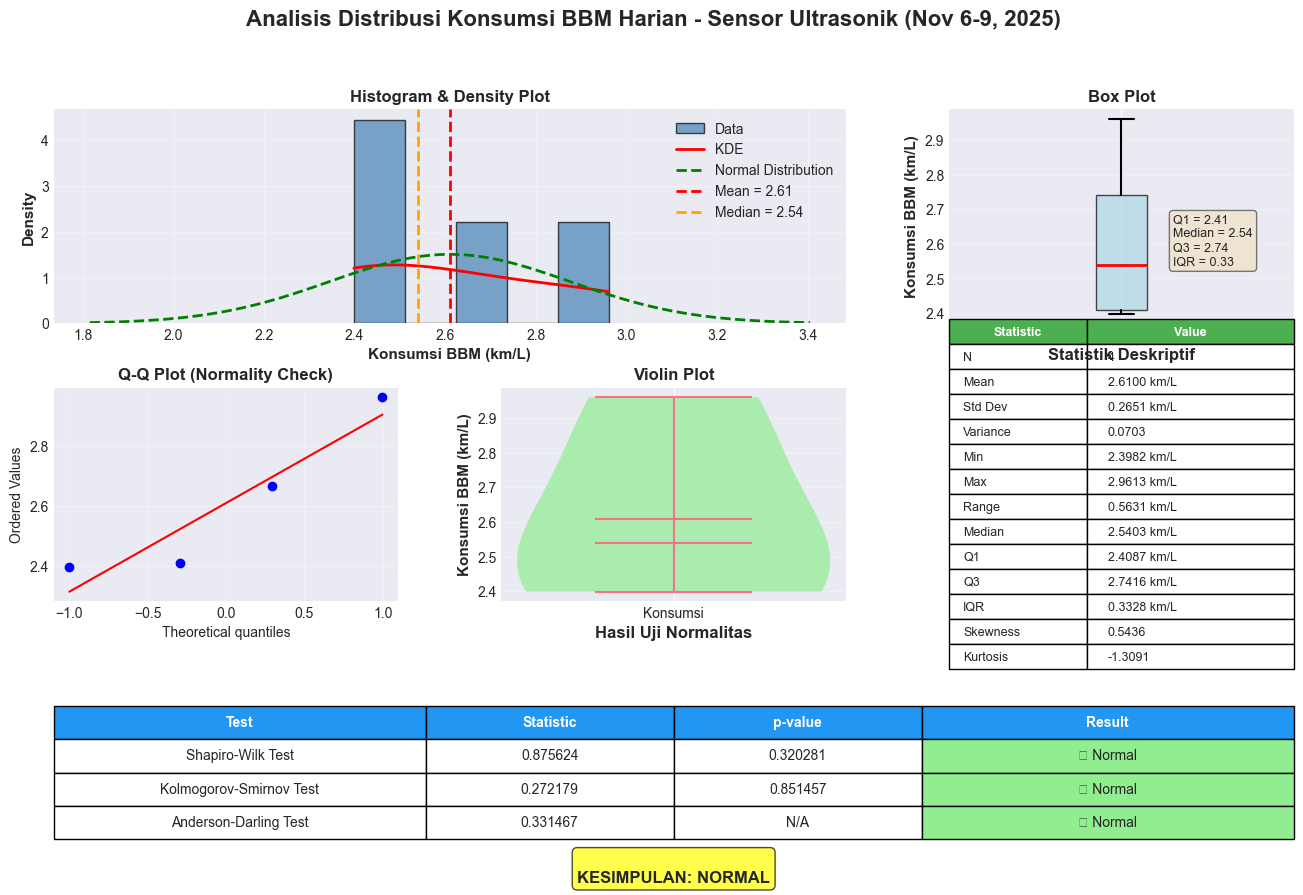

In [13]:
# ============================================================================
# VISUALISASI 1: DISTRIBUSI KONSUMSI BBM HARIAN
# ============================================================================

def plot_consumption_distribution(daily_df, stats_dict, normality_dict, title_suffix=""):
    """
    Visualisasi distribusi konsumsi BBM harian dengan multiple plots
    """
    if len(daily_df) == 0:
        print("Tidak ada data untuk divisualisasikan")
        return
    
    consumption = daily_df['avg_consumption_kmL'].values
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Main title
    fig.suptitle(f'Analisis Distribusi Konsumsi BBM Harian {title_suffix}', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # 1. HISTOGRAM WITH KDE
    ax1 = fig.add_subplot(gs[0, :2])
    n, bins, patches = ax1.hist(consumption, bins=max(5, len(consumption)//2), 
                                  alpha=0.7, color='steelblue', edgecolor='black',
                                  density=True, label='Data')
    
    # Add KDE
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(consumption)
    x_range = np.linspace(consumption.min(), consumption.max(), 100)
    ax1.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    # Add normal distribution overlay
    mu, sigma = stats_dict['Mean'], stats_dict['Std_Dev']
    x_normal = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    ax1.plot(x_normal, stats.norm.pdf(x_normal, mu, sigma), 
             'g--', linewidth=2, label='Normal Distribution')
    
    ax1.axvline(mu, color='red', linestyle='--', linewidth=2, label=f'Mean = {mu:.2f}')
    ax1.axvline(stats_dict['Median'], color='orange', linestyle='--', 
                linewidth=2, label=f'Median = {stats_dict["Median"]:.2f}')
    
    ax1.set_xlabel('Konsumsi BBM (km/L)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax1.set_title('Histogram & Density Plot', fontsize=12, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(alpha=0.3)
    
    # 2. BOX PLOT
    ax2 = fig.add_subplot(gs[0, 2])
    bp = ax2.boxplot(consumption, vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5))
    
    ax2.set_ylabel('Konsumsi BBM (km/L)', fontsize=11, fontweight='bold')
    ax2.set_title('Box Plot', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add statistics text
    stats_text = f'Q1 = {stats_dict["Q1"]:.2f}\nMedian = {stats_dict["Median"]:.2f}\nQ3 = {stats_dict["Q3"]:.2f}\nIQR = {stats_dict["IQR"]:.2f}'
    ax2.text(1.15, stats_dict['Median'], stats_text, fontsize=9,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 3. Q-Q PLOT
    ax3 = fig.add_subplot(gs[1, 0])
    stats.probplot(consumption, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
    ax3.grid(alpha=0.3)
    
    # 4. VIOLIN PLOT
    ax4 = fig.add_subplot(gs[1, 1])
    parts = ax4.violinplot([consumption], positions=[1], showmeans=True, 
                           showmedians=True, widths=0.7)
    
    for pc in parts['bodies']:
        pc.set_facecolor('lightgreen')
        pc.set_alpha(0.7)
    
    ax4.set_ylabel('Konsumsi BBM (km/L)', fontsize=11, fontweight='bold')
    ax4.set_title('Violin Plot', fontsize=12, fontweight='bold')
    ax4.set_xticks([1])
    ax4.set_xticklabels(['Konsumsi'])
    ax4.grid(axis='y', alpha=0.3)
    
    # 5. STATISTICAL SUMMARY TABLE
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.axis('off')
    
    stats_data = [
        ['N', f"{stats_dict['N']}"],
        ['Mean', f"{stats_dict['Mean']:.4f} km/L"],
        ['Std Dev', f"{stats_dict['Std_Dev']:.4f} km/L"],
        ['Variance', f"{stats_dict['Variance']:.4f}"],
        ['Min', f"{stats_dict['Min']:.4f} km/L"],
        ['Max', f"{stats_dict['Max']:.4f} km/L"],
        ['Range', f"{stats_dict['Range']:.4f} km/L"],
        ['Median', f"{stats_dict['Median']:.4f} km/L"],
        ['Q1', f"{stats_dict['Q1']:.4f} km/L"],
        ['Q3', f"{stats_dict['Q3']:.4f} km/L"],
        ['IQR', f"{stats_dict['IQR']:.4f} km/L"],
        ['Skewness', f"{stats_dict['Skewness']:.4f}"],
        ['Kurtosis', f"{stats_dict['Kurtosis']:.4f}"]
    ]
    
    table = ax5.table(cellText=stats_data, colLabels=['Statistic', 'Value'],
                     loc='center', cellLoc='left', colWidths=[0.4, 0.6])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    
    # Color header
    for i in range(2):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax5.set_title('Statistik Deskriptif', fontsize=12, fontweight='bold', pad=20)
    
    # 6. NORMALITY TEST RESULTS
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('off')
    
    if normality_dict:
        normality_data = [
            ['Shapiro-Wilk Test', 
             f"{normality_dict['shapiro_stat']:.6f}",
             f"{normality_dict['shapiro_pvalue']:.6f}",
             '✓ Normal' if normality_dict['shapiro_normal'] else '✗ Not Normal'],
            ['Kolmogorov-Smirnov Test',
             f"{normality_dict['ks_stat']:.6f}",
             f"{normality_dict['ks_pvalue']:.6f}",
             '✓ Normal' if normality_dict['ks_normal'] else '✗ Not Normal'],
            ['Anderson-Darling Test',
             f"{normality_dict['anderson_stat']:.6f}",
             'N/A',
             '✓ Normal' if normality_dict['anderson_normal'] else '✗ Not Normal']
        ]
        
        table2 = ax6.table(cellText=normality_data, 
                          colLabels=['Test', 'Statistic', 'p-value', 'Result'],
                          loc='center', cellLoc='center', 
                          colWidths=[0.3, 0.2, 0.2, 0.3])
        table2.auto_set_font_size(False)
        table2.set_fontsize(10)
        table2.scale(1, 2)
        
        # Color header
        for i in range(4):
            table2[(0, i)].set_facecolor('#2196F3')
            table2[(0, i)].set_text_props(weight='bold', color='white')
        
        # Color results
        for i in range(1, 4):
            if 'Normal' in normality_data[i-1][3]:
                table2[(i, 3)].set_facecolor('#90EE90')
            else:
                table2[(i, 3)].set_facecolor('#FFB6C1')
        
        conclusion_text = f"\nKESIMPULAN: {normality_dict['conclusion']}"
        ax6.text(0.5, 0.05, conclusion_text, ha='center', va='center',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
        
        ax6.set_title('Hasil Uji Normalitas', fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig


# VISUALISASI DATA BARU (INTERPOLATED)
print("\n" + "="*80)
print("VISUALISASI DATA SENSOR ULTRASONIK (SETELAH INTERPOLASI)")
print("="*80)

if len(daily_baru_interpolated) > 0:
    stats_baru_interpolated = descriptive_statistics(daily_baru_interpolated)
    fig1 = plot_consumption_distribution(
        daily_baru_interpolated, 
        stats_baru_interpolated, 
        normality_baru_interpolated,
        title_suffix="- Sensor Ultrasonik (Nov 6-9, 2025)"
    )
    plt.show()
else:
    print("Tidak ada data untuk divisualisasikan")


VISUALISASI TIME SERIES - SENSOR ULTRASONIK


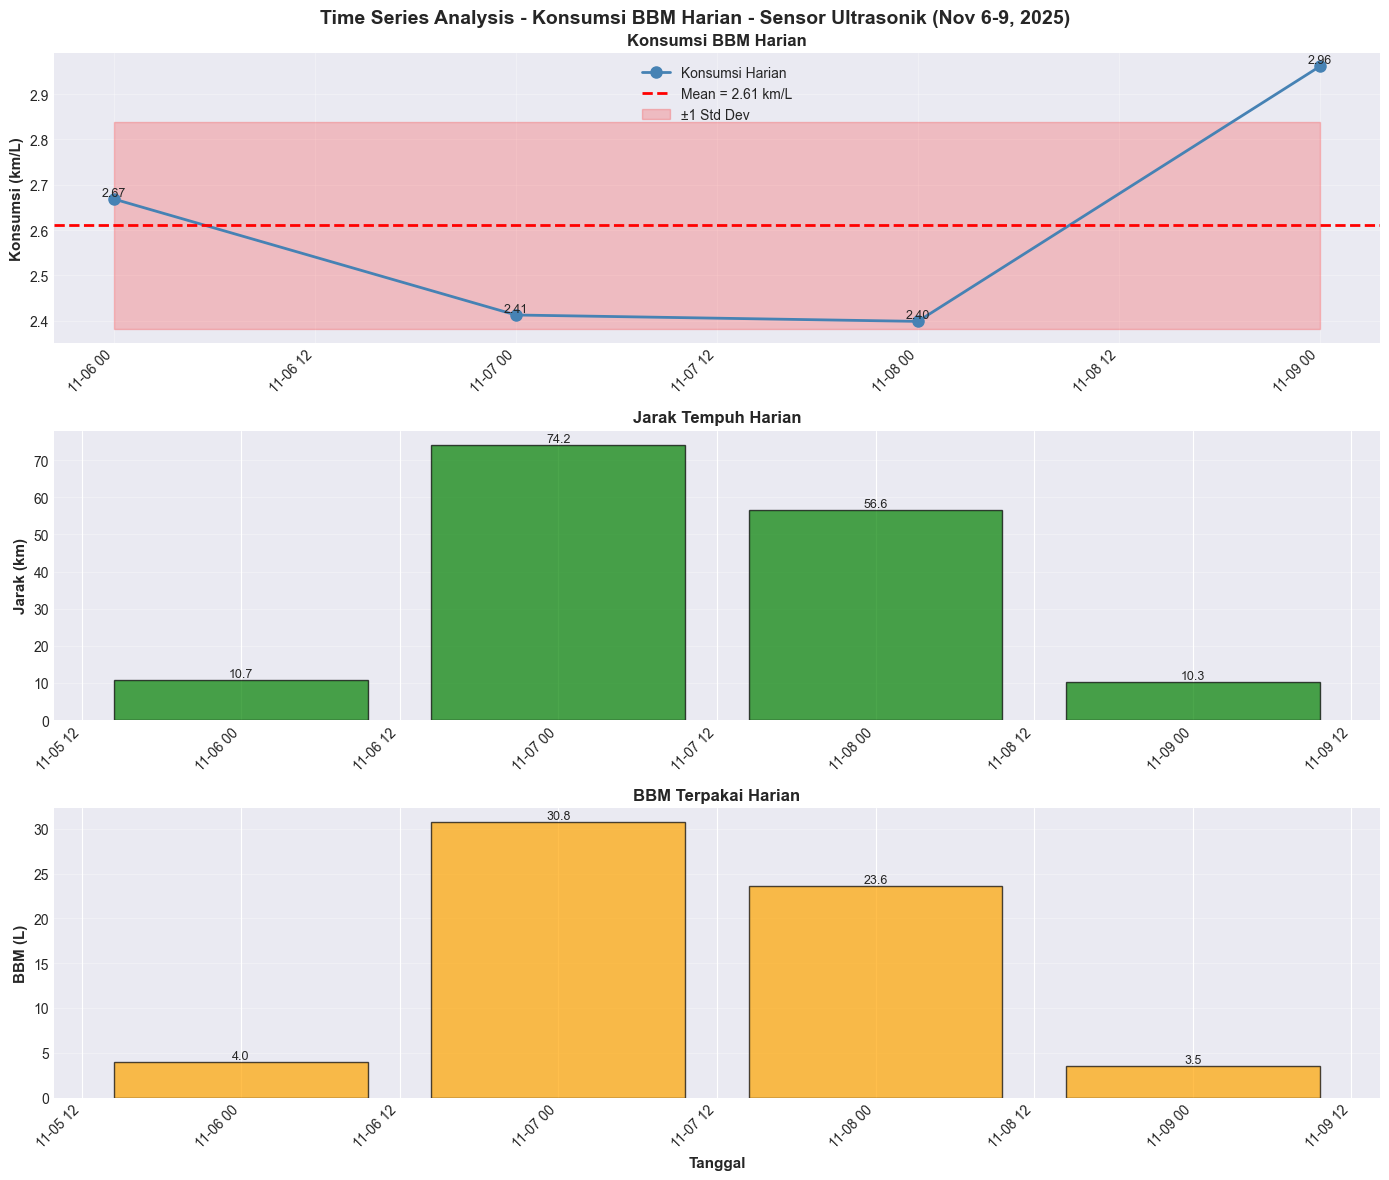

In [14]:
# ============================================================================
# VISUALISASI 2: TIME SERIES KONSUMSI HARIAN
# ============================================================================

def plot_daily_timeseries(daily_df, title_suffix=""):
    """
    Visualisasi time series konsumsi BBM harian
    """
    if len(daily_df) == 0:
        print("Tidak ada data untuk divisualisasikan")
        return
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    fig.suptitle(f'Time Series Analysis - Konsumsi BBM Harian {title_suffix}', 
                 fontsize=14, fontweight='bold')
    
    # Prepare data
    daily_df = daily_df.sort_values('date').reset_index(drop=True)
    dates = pd.to_datetime(daily_df['date'])
    consumption = daily_df['avg_consumption_kmL'].values
    
    # 1. KONSUMSI BBM HARIAN
    ax1 = axes[0]
    ax1.plot(dates, consumption, 'o-', linewidth=2, markersize=8, 
             color='steelblue', label='Konsumsi Harian')
    ax1.axhline(consumption.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean = {consumption.mean():.2f} km/L')
    ax1.fill_between(dates, 
                     consumption.mean() - consumption.std(),
                     consumption.mean() + consumption.std(),
                     alpha=0.2, color='red', label='±1 Std Dev')
    
    ax1.set_ylabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
    ax1.set_title('Konsumsi BBM Harian', fontsize=12, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(alpha=0.3)
    
    # Add value labels
    for i, (date, val) in enumerate(zip(dates, consumption)):
        ax1.text(date, val, f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    # 2. JARAK TEMPUH HARIAN
    ax2 = axes[1]
    distance = daily_df['distance_km'].values
    ax2.bar(dates, distance, color='green', alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Jarak (km)', fontsize=11, fontweight='bold')
    ax2.set_title('Jarak Tempuh Harian', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (date, val) in enumerate(zip(dates, distance)):
        ax2.text(date, val, f'{val:.1f}', ha='center', va='bottom', fontsize=9)
    
    # 3. BBM TERPAKAI HARIAN
    ax3 = axes[2]
    fuel_used = daily_df['fuel_used_L'].values
    ax3.bar(dates, fuel_used, color='orange', alpha=0.7, edgecolor='black')
    ax3.set_ylabel('BBM (L)', fontsize=11, fontweight='bold')
    ax3.set_xlabel('Tanggal', fontsize=11, fontweight='bold')
    ax3.set_title('BBM Terpakai Harian', fontsize=12, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (date, val) in enumerate(zip(dates, fuel_used)):
        ax3.text(date, val, f'{val:.1f}', ha='center', va='bottom', fontsize=9)
    
    # Format x-axis
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    return fig


# VISUALISASI TIME SERIES
print("\n" + "="*80)
print("VISUALISASI TIME SERIES - SENSOR ULTRASONIK")
print("="*80)

if len(daily_baru_interpolated) > 0:
    fig2 = plot_daily_timeseries(
        daily_baru_interpolated,
        title_suffix="- Sensor Ultrasonik (Nov 6-9, 2025)"
    )
    plt.show()


SCATTER PLOT ANALYSIS - SENSOR ULTRASONIK


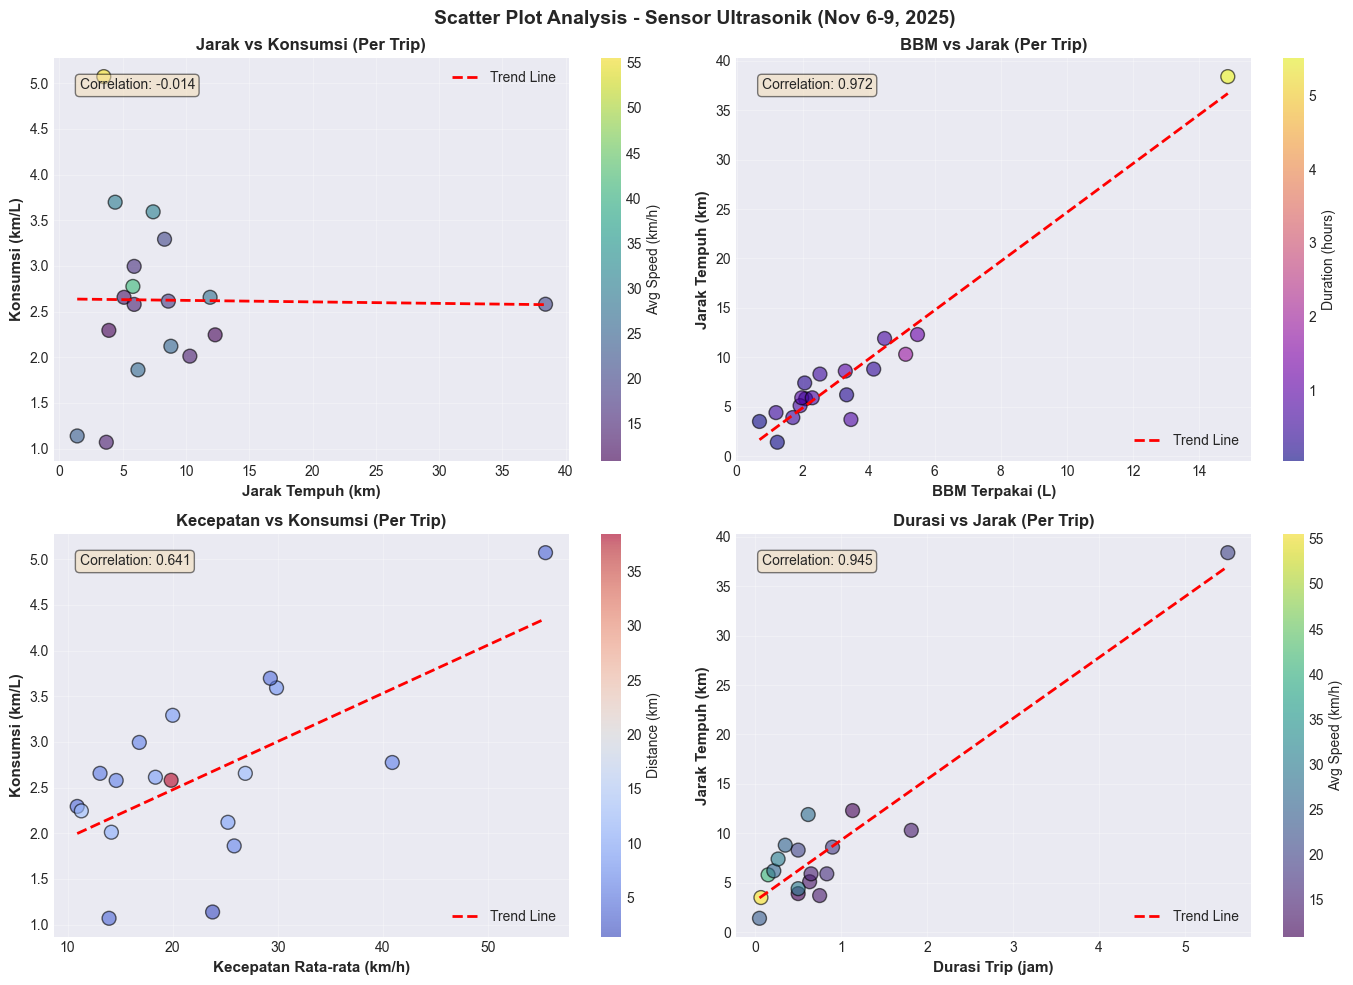

In [15]:
# ============================================================================
# VISUALISASI 3: SCATTER PLOT ANALISIS
# ============================================================================

def plot_scatter_analysis(trip_df, daily_df, title_suffix=""):
    """
    Scatter plot untuk analisis hubungan antar variabel
    """
    if len(trip_df) == 0:
        print("Tidak ada data trip untuk divisualisasikan")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Scatter Plot Analysis {title_suffix}', 
                 fontsize=14, fontweight='bold')
    
    # 1. JARAK vs KONSUMSI (Trip Level)
    ax1 = axes[0, 0]
    scatter1 = ax1.scatter(trip_df['distance_km'], trip_df['consumption_kmL'],
                          c=trip_df['avg_speed'], cmap='viridis', 
                          s=100, alpha=0.6, edgecolors='black')
    
    # Add regression line
    z = np.polyfit(trip_df['distance_km'], trip_df['consumption_kmL'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(trip_df['distance_km'].min(), 
                        trip_df['distance_km'].max(), 100)
    ax1.plot(x_line, p(x_line), "r--", linewidth=2, label='Trend Line')
    
    ax1.set_xlabel('Jarak Tempuh (km)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
    ax1.set_title('Jarak vs Konsumsi (Per Trip)', fontsize=12, fontweight='bold')
    ax1.grid(alpha=0.3)
    ax1.legend()
    
    # Add colorbar
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label('Avg Speed (km/h)', fontsize=10)
    
    # Calculate correlation
    corr1 = np.corrcoef(trip_df['distance_km'], trip_df['consumption_kmL'])[0, 1]
    ax1.text(0.05, 0.95, f'Correlation: {corr1:.3f}', 
             transform=ax1.transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             verticalalignment='top')
    
    # 2. BBM TERPAKAI vs JARAK (Trip Level)
    ax2 = axes[0, 1]
    scatter2 = ax2.scatter(trip_df['fuel_used_L'], trip_df['distance_km'],
                          c=trip_df['duration_hours'], cmap='plasma',
                          s=100, alpha=0.6, edgecolors='black')
    
    # Add regression line
    z2 = np.polyfit(trip_df['fuel_used_L'], trip_df['distance_km'], 1)
    p2 = np.poly1d(z2)
    x_line2 = np.linspace(trip_df['fuel_used_L'].min(),
                         trip_df['fuel_used_L'].max(), 100)
    ax2.plot(x_line2, p2(x_line2), "r--", linewidth=2, label='Trend Line')
    
    ax2.set_xlabel('BBM Terpakai (L)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Jarak Tempuh (km)', fontsize=11, fontweight='bold')
    ax2.set_title('BBM vs Jarak (Per Trip)', fontsize=12, fontweight='bold')
    ax2.grid(alpha=0.3)
    ax2.legend()
    
    # Add colorbar
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Duration (hours)', fontsize=10)
    
    # Calculate correlation
    corr2 = np.corrcoef(trip_df['fuel_used_L'], trip_df['distance_km'])[0, 1]
    ax2.text(0.05, 0.95, f'Correlation: {corr2:.3f}',
             transform=ax2.transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             verticalalignment='top')
    
    # 3. KECEPATAN vs KONSUMSI (Trip Level)
    ax3 = axes[1, 0]
    scatter3 = ax3.scatter(trip_df['avg_speed'], trip_df['consumption_kmL'],
                          c=trip_df['distance_km'], cmap='coolwarm',
                          s=100, alpha=0.6, edgecolors='black')
    
    # Add regression line
    z3 = np.polyfit(trip_df['avg_speed'], trip_df['consumption_kmL'], 1)
    p3 = np.poly1d(z3)
    x_line3 = np.linspace(trip_df['avg_speed'].min(),
                         trip_df['avg_speed'].max(), 100)
    ax3.plot(x_line3, p3(x_line3), "r--", linewidth=2, label='Trend Line')
    
    ax3.set_xlabel('Kecepatan Rata-rata (km/h)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
    ax3.set_title('Kecepatan vs Konsumsi (Per Trip)', fontsize=12, fontweight='bold')
    ax3.grid(alpha=0.3)
    ax3.legend()
    
    # Add colorbar
    cbar3 = plt.colorbar(scatter3, ax=ax3)
    cbar3.set_label('Distance (km)', fontsize=10)
    
    # Calculate correlation
    corr3 = np.corrcoef(trip_df['avg_speed'], trip_df['consumption_kmL'])[0, 1]
    ax3.text(0.05, 0.95, f'Correlation: {corr3:.3f}',
             transform=ax3.transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             verticalalignment='top')
    
    # 4. DURASI vs JARAK (Trip Level)
    ax4 = axes[1, 1]
    scatter4 = ax4.scatter(trip_df['duration_hours'], trip_df['distance_km'],
                          c=trip_df['avg_speed'], cmap='viridis',
                          s=100, alpha=0.6, edgecolors='black')
    
    # Add regression line
    z4 = np.polyfit(trip_df['duration_hours'], trip_df['distance_km'], 1)
    p4 = np.poly1d(z4)
    x_line4 = np.linspace(trip_df['duration_hours'].min(),
                         trip_df['duration_hours'].max(), 100)
    ax4.plot(x_line4, p4(x_line4), "r--", linewidth=2, label='Trend Line')
    
    ax4.set_xlabel('Durasi Trip (jam)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Jarak Tempuh (km)', fontsize=11, fontweight='bold')
    ax4.set_title('Durasi vs Jarak (Per Trip)', fontsize=12, fontweight='bold')
    ax4.grid(alpha=0.3)
    ax4.legend()
    
    # Add colorbar
    cbar4 = plt.colorbar(scatter4, ax=ax4)
    cbar4.set_label('Avg Speed (km/h)', fontsize=10)
    
    # Calculate correlation
    corr4 = np.corrcoef(trip_df['duration_hours'], trip_df['distance_km'])[0, 1]
    ax4.text(0.05, 0.95, f'Correlation: {corr4:.3f}',
             transform=ax4.transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             verticalalignment='top')
    
    plt.tight_layout()
    return fig


# VISUALISASI SCATTER PLOT
print("\n" + "="*80)
print("SCATTER PLOT ANALYSIS - SENSOR ULTRASONIK")
print("="*80)

if len(trips_baru_interpolated) > 0:
    fig3 = plot_scatter_analysis(
        trips_baru_interpolated,
        daily_baru_interpolated,
        title_suffix="- Sensor Ultrasonik (Nov 6-9, 2025)"
    )
    plt.show()


CORRELATION HEATMAP - SENSOR ULTRASONIK


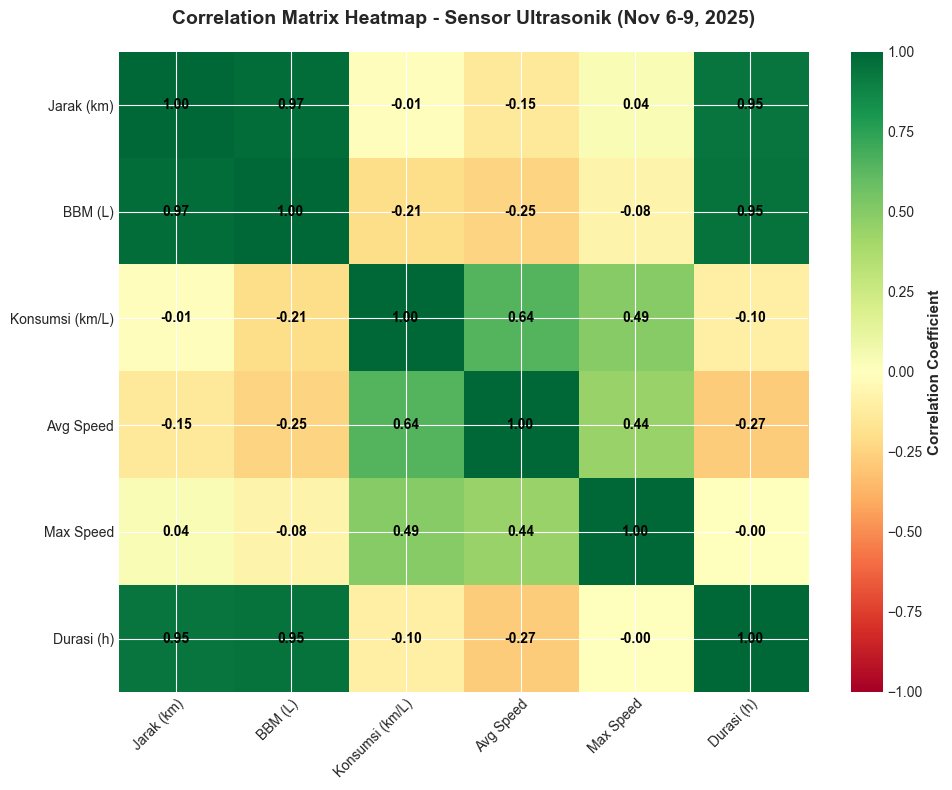

In [16]:
# ============================================================================
# VISUALISASI 4: HEATMAP KORELASI
# ============================================================================

def plot_correlation_heatmap(trip_df, title_suffix=""):
    """
    Heatmap korelasi antar variabel
    """
    if len(trip_df) == 0:
        print("Tidak ada data untuk divisualisasikan")
        return
    
    # Select numeric columns
    numeric_cols = ['distance_km', 'fuel_used_L', 'consumption_kmL', 
                   'avg_speed', 'max_speed', 'duration_hours']
    
    # Calculate correlation matrix
    corr_matrix = trip_df[numeric_cols].corr()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(numeric_cols)))
    ax.set_yticks(np.arange(len(numeric_cols)))
    ax.set_xticklabels(['Jarak (km)', 'BBM (L)', 'Konsumsi (km/L)', 
                        'Avg Speed', 'Max Speed', 'Durasi (h)'])
    ax.set_yticklabels(['Jarak (km)', 'BBM (L)', 'Konsumsi (km/L)', 
                        'Avg Speed', 'Max Speed', 'Durasi (h)'])
    
    # Rotate the tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations
    for i in range(len(numeric_cols)):
        for j in range(len(numeric_cols)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha="center", va="center", color="black", fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Correlation Coefficient', fontsize=11, fontweight='bold')
    
    ax.set_title(f'Correlation Matrix Heatmap {title_suffix}', 
                 fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig


# VISUALISASI HEATMAP
print("\n" + "="*80)
print("CORRELATION HEATMAP - SENSOR ULTRASONIK")
print("="*80)

if len(trips_baru_interpolated) > 0:
    fig4 = plot_correlation_heatmap(
        trips_baru_interpolated,
        title_suffix="- Sensor Ultrasonik (Nov 6-9, 2025)"
    )
    plt.show()


PERBANDINGAN: SEBELUM vs SESUDAH INTERPOLASI


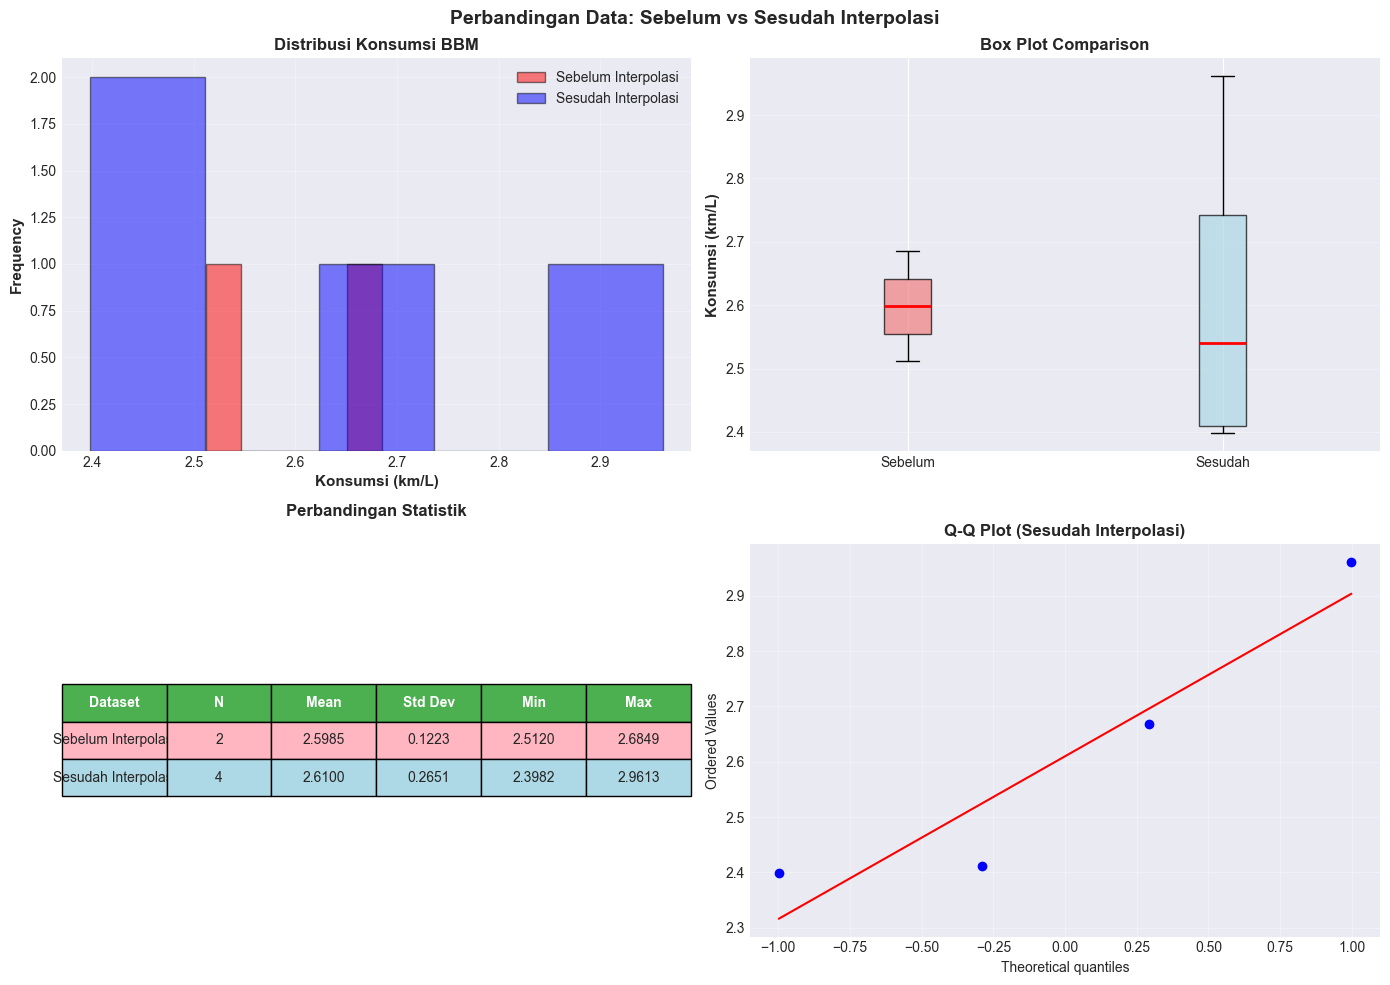

In [17]:
# ============================================================================
# VISUALISASI 5: COMPARISON BEFORE & AFTER INTERPOLATION
# ============================================================================

def plot_interpolation_comparison(daily_before, daily_after):
    """
    Perbandingan sebelum dan sesudah interpolasi
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Perbandingan Data: Sebelum vs Sesudah Interpolasi', 
                 fontsize=14, fontweight='bold')
    
    # 1. HISTOGRAM COMPARISON
    ax1 = axes[0, 0]
    if len(daily_before) > 0:
        ax1.hist(daily_before['avg_consumption_kmL'], bins=5, alpha=0.5, 
                label='Sebelum Interpolasi', color='red', edgecolor='black')
    if len(daily_after) > 0:
        ax1.hist(daily_after['avg_consumption_kmL'], bins=5, alpha=0.5,
                label='Sesudah Interpolasi', color='blue', edgecolor='black')
    ax1.set_xlabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax1.set_title('Distribusi Konsumsi BBM', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 2. BOX PLOT COMPARISON
    ax2 = axes[0, 1]
    data_to_plot = []
    labels = []
    if len(daily_before) > 0:
        data_to_plot.append(daily_before['avg_consumption_kmL'].values)
        labels.append('Sebelum')
    if len(daily_after) > 0:
        data_to_plot.append(daily_after['avg_consumption_kmL'].values)
        labels.append('Sesudah')
    
    if data_to_plot:
        bp = ax2.boxplot(data_to_plot, labels=labels, patch_artist=True,
                        boxprops=dict(alpha=0.7),
                        medianprops=dict(color='red', linewidth=2))
        
        # Color boxes
        colors = ['lightcoral', 'lightblue']
        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
            patch.set_facecolor(color)
    
    ax2.set_ylabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
    ax2.set_title('Box Plot Comparison', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. STATISTICS COMPARISON TABLE
    ax3 = axes[1, 0]
    ax3.axis('off')
    
    stats_comparison = []
    
    if len(daily_before) > 0:
        before_data = daily_before['avg_consumption_kmL'].values
        stats_comparison.append([
            'Sebelum Interpolasi',
            f'{len(before_data)}',
            f'{np.mean(before_data):.4f}',
            f'{np.std(before_data, ddof=1):.4f}',
            f'{np.min(before_data):.4f}',
            f'{np.max(before_data):.4f}'
        ])
    
    if len(daily_after) > 0:
        after_data = daily_after['avg_consumption_kmL'].values
        stats_comparison.append([
            'Sesudah Interpolasi',
            f'{len(after_data)}',
            f'{np.mean(after_data):.4f}',
            f'{np.std(after_data, ddof=1):.4f}',
            f'{np.min(after_data):.4f}',
            f'{np.max(after_data):.4f}'
        ])
    
    if stats_comparison:
        table = ax3.table(cellText=stats_comparison,
                         colLabels=['Dataset', 'N', 'Mean', 'Std Dev', 'Min', 'Max'],
                         loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        
        # Color header
        for i in range(6):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # Color rows
        colors = ['#FFB6C1', '#ADD8E6']
        for i, color in enumerate(colors[:len(stats_comparison)], start=1):
            for j in range(6):
                table[(i, j)].set_facecolor(color)
    
    ax3.set_title('Perbandingan Statistik', fontsize=12, fontweight='bold', pad=20)
    
    # 4. Q-Q PLOT COMPARISON
    ax4 = axes[1, 1]
    
    if len(daily_after) > 0:
        stats.probplot(daily_after['avg_consumption_kmL'].values, 
                      dist="norm", plot=ax4)
        ax4.set_title('Q-Q Plot (Sesudah Interpolasi)', 
                     fontsize=12, fontweight='bold')
        ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig


# VISUALISASI COMPARISON
print("\n" + "="*80)
print("PERBANDINGAN: SEBELUM vs SESUDAH INTERPOLASI")
print("="*80)

fig5 = plot_interpolation_comparison(daily_baru, daily_baru_interpolated)
plt.show()


DASHBOARD RINGKASAN - SENSOR ULTRASONIK


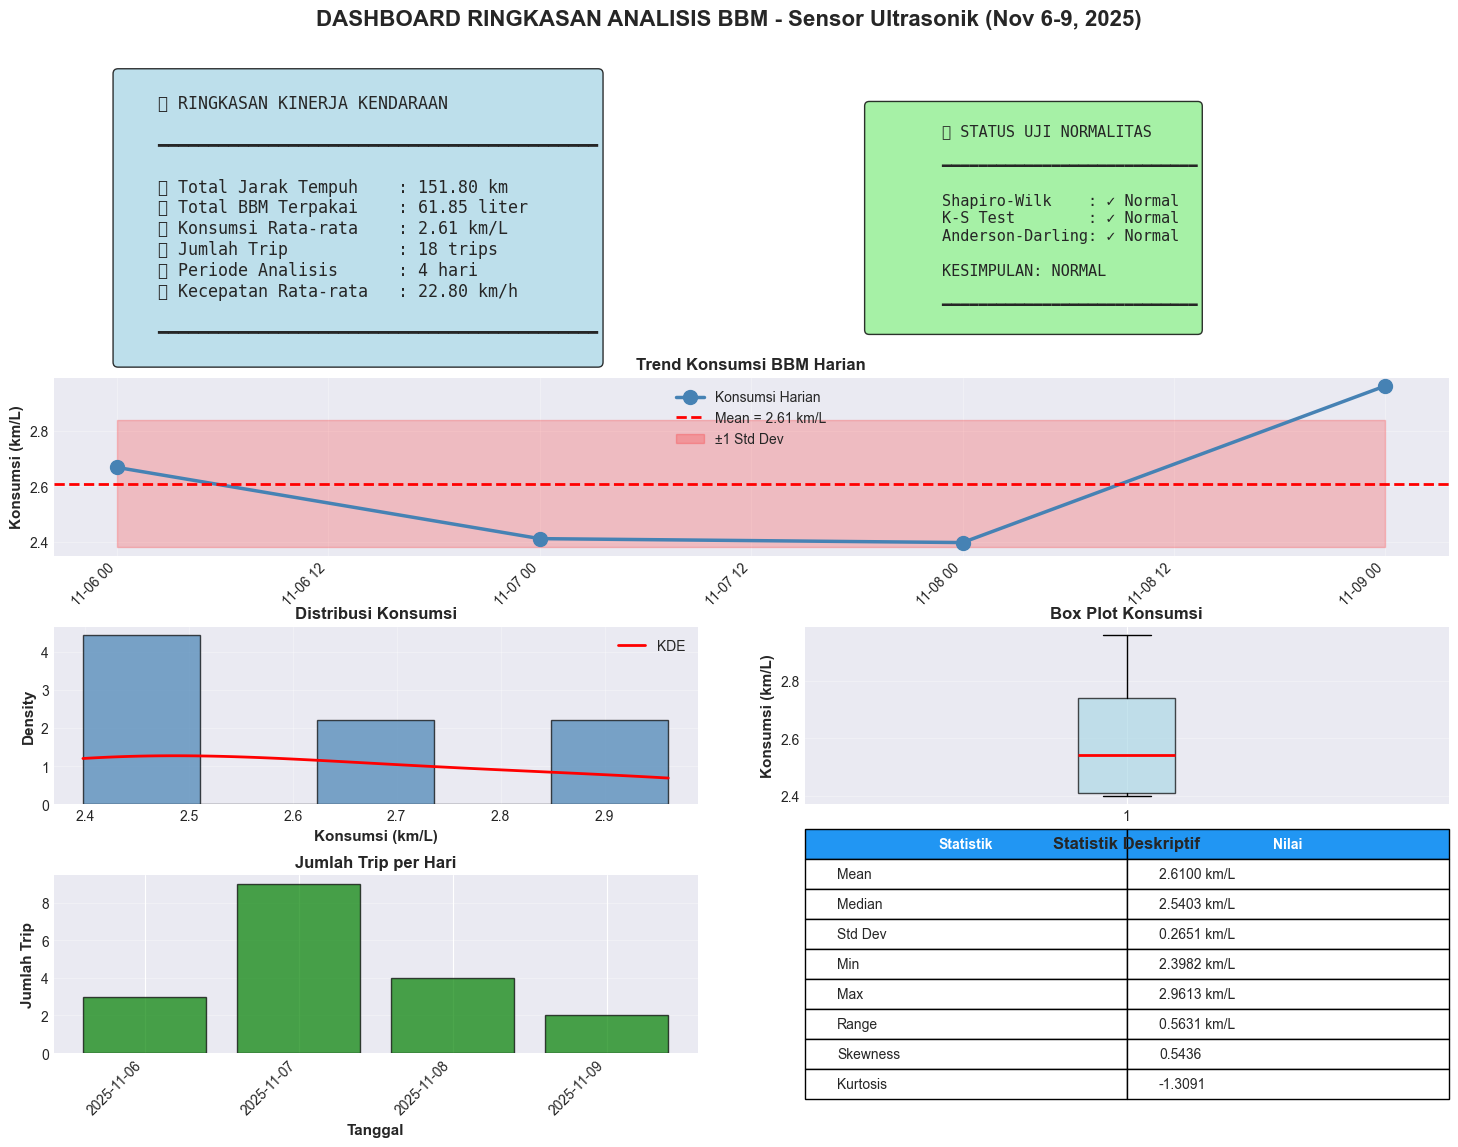

In [18]:
# ============================================================================
# VISUALISASI 6: SUMMARY DASHBOARD
# ============================================================================

def create_summary_dashboard(daily_df, trip_df, stats_dict, normality_dict, title=""):
    """
    Dashboard ringkasan lengkap
    """
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.4)
    
    fig.suptitle(f'DASHBOARD RINGKASAN ANALISIS BBM {title}', 
                 fontsize=16, fontweight='bold')
    
    # 1. KEY METRICS (Top row - spans 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.axis('off')
    
    # Calculate key metrics
    total_distance = daily_df['distance_km'].sum()
    total_fuel = daily_df['fuel_used_L'].sum()
    avg_consumption = stats_dict['Mean']
    total_trips = daily_df['num_trips'].sum()
    total_days = len(daily_df)
    avg_speed = trip_df['avg_speed'].mean()
    
    metrics_text = f"""
    📊 RINGKASAN KINERJA KENDARAAN
    
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    🚗 Total Jarak Tempuh    : {total_distance:.2f} km
    ⛽ Total BBM Terpakai    : {total_fuel:.2f} liter
    📈 Konsumsi Rata-rata    : {avg_consumption:.2f} km/L
    🔢 Jumlah Trip           : {int(total_trips)} trips
    📅 Periode Analisis      : {total_days} hari
    🏃 Kecepatan Rata-rata   : {avg_speed:.2f} km/h
    
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    """
    
    ax1.text(0.1, 0.5, metrics_text, fontsize=12, family='monospace',
            verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # 2. NORMALITY STATUS (Top right)
    ax2 = fig.add_subplot(gs[0, 2:])
    ax2.axis('off')
    
    if normality_dict:
        normality_text = f"""
        📊 STATUS UJI NORMALITAS
        
        ━━━━━━━━━━━━━━━━━━━━━━━━━━━━
        
        Shapiro-Wilk    : {'✓ Normal' if normality_dict['shapiro_normal'] else '✗ Not Normal'}
        K-S Test        : {'✓ Normal' if normality_dict['ks_normal'] else '✗ Not Normal'}
        Anderson-Darling: {'✓ Normal' if normality_dict['anderson_normal'] else '✗ Not Normal'}
        
        KESIMPULAN: {normality_dict['conclusion']}
        
        ━━━━━━━━━━━━━━━━━━━━━━━━━━━━
        """
        
        color = 'lightgreen' if normality_dict['conclusion'] == 'NORMAL' else 'lightyellow'
        ax2.text(0.1, 0.5, normality_text, fontsize=11, family='monospace',
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
    
    # 3. CONSUMPTION TREND (Row 2, spans all columns)
    ax3 = fig.add_subplot(gs[1, :])
    dates = pd.to_datetime(daily_df['date'])
    consumption = daily_df['avg_consumption_kmL'].values
    
    ax3.plot(dates, consumption, 'o-', linewidth=2.5, markersize=10,
            color='steelblue', label='Konsumsi Harian')
    ax3.axhline(consumption.mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean = {consumption.mean():.2f} km/L')
    ax3.fill_between(dates,
                    consumption.mean() - consumption.std(),
                    consumption.mean() + consumption.std(),
                    alpha=0.2, color='red', label='±1 Std Dev')
    
    ax3.set_ylabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
    ax3.set_title('Trend Konsumsi BBM Harian', fontsize=12, fontweight='bold')
    ax3.legend(loc='best')
    ax3.grid(alpha=0.3)
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 4. DISTRIBUTION (Row 3, left)
    ax4 = fig.add_subplot(gs[2, :2])
    ax4.hist(consumption, bins=max(5, len(consumption)//2), 
            alpha=0.7, color='steelblue', edgecolor='black', density=True)
    
    # Add KDE
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(consumption)
    x_range = np.linspace(consumption.min(), consumption.max(), 100)
    ax4.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    ax4.set_xlabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax4.set_title('Distribusi Konsumsi', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # 5. BOX PLOT (Row 3, right)
    ax5 = fig.add_subplot(gs[2, 2:])
    bp = ax5.boxplot(consumption, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
    
    ax5.set_ylabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
    ax5.set_title('Box Plot Konsumsi', fontsize=12, fontweight='bold')
    ax5.grid(axis='y', alpha=0.3)
    
    # 6. TRIP SUMMARY (Row 4, left)
    ax6 = fig.add_subplot(gs[3, :2])
    
    trip_summary = trip_df.groupby(pd.to_datetime(trip_df['start_time']).dt.date).size()
    ax6.bar(range(len(trip_summary)), trip_summary.values, 
           color='green', alpha=0.7, edgecolor='black')
    ax6.set_xticks(range(len(trip_summary)))
    ax6.set_xticklabels([str(d) for d in trip_summary.index], rotation=45, ha='right')
    ax6.set_ylabel('Jumlah Trip', fontsize=11, fontweight='bold')
    ax6.set_xlabel('Tanggal', fontsize=11, fontweight='bold')
    ax6.set_title('Jumlah Trip per Hari', fontsize=12, fontweight='bold')
    ax6.grid(axis='y', alpha=0.3)
    
    # 7. STATISTICS TABLE (Row 4, right)
    ax7 = fig.add_subplot(gs[3, 2:])
    ax7.axis('off')
    
    stats_data = [
        ['Mean', f"{stats_dict['Mean']:.4f} km/L"],
        ['Median', f"{stats_dict['Median']:.4f} km/L"],
        ['Std Dev', f"{stats_dict['Std_Dev']:.4f} km/L"],
        ['Min', f"{stats_dict['Min']:.4f} km/L"],
        ['Max', f"{stats_dict['Max']:.4f} km/L"],
        ['Range', f"{stats_dict['Range']:.4f} km/L"],
        ['Skewness', f"{stats_dict['Skewness']:.4f}"],
        ['Kurtosis', f"{stats_dict['Kurtosis']:.4f}"]
    ]
    
    table = ax7.table(cellText=stats_data, colLabels=['Statistik', 'Nilai'],
                     loc='center', cellLoc='left', colWidths=[0.5, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.8)
    
    # Color header
    for i in range(2):
        table[(0, i)].set_facecolor('#2196F3')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax7.set_title('Statistik Deskriptif', fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig


# DASHBOARD SUMMARY
print("\n" + "="*80)
print("DASHBOARD RINGKASAN - SENSOR ULTRASONIK")
print("="*80)

if len(daily_baru_interpolated) > 0 and len(trips_baru_interpolated) > 0:
    fig6 = create_summary_dashboard(
        daily_baru_interpolated,
        trips_baru_interpolated,
        stats_baru_interpolated,
        normality_baru_interpolated,
        title="- Sensor Ultrasonik (Nov 6-9, 2025)"
    )
    plt.show()


DASHBOARD RINGKASAN - SENSOR ULTRASONIK


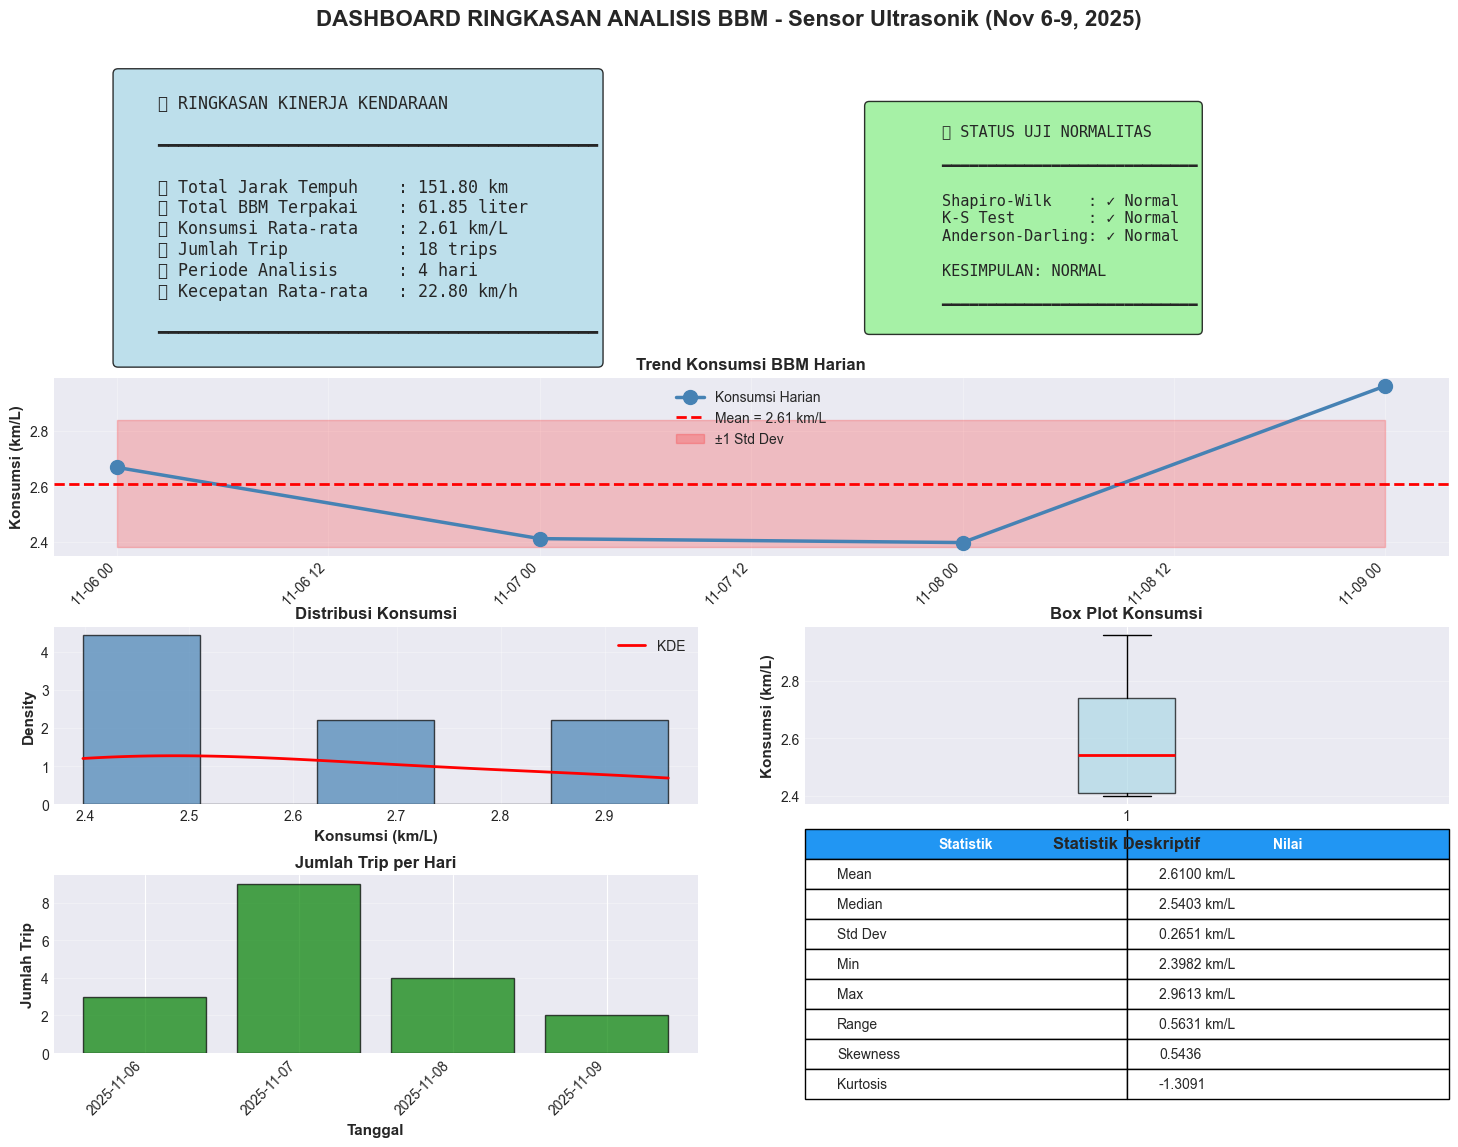

In [19]:
# ============================================================================
# VISUALISASI 6: SUMMARY DASHBOARD
# ============================================================================

def create_summary_dashboard(daily_df, trip_df, stats_dict, normality_dict, title=""):
    """
    Dashboard ringkasan lengkap
    """
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.4)
    
    fig.suptitle(f'DASHBOARD RINGKASAN ANALISIS BBM {title}', 
                 fontsize=16, fontweight='bold')
    
    # 1. KEY METRICS (Top row - spans 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.axis('off')
    
    # Calculate key metrics
    total_distance = daily_df['distance_km'].sum()
    total_fuel = daily_df['fuel_used_L'].sum()
    avg_consumption = stats_dict['Mean']
    total_trips = daily_df['num_trips'].sum()
    total_days = len(daily_df)
    avg_speed = trip_df['avg_speed'].mean()
    
    metrics_text = f"""
    📊 RINGKASAN KINERJA KENDARAAN
    
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    🚗 Total Jarak Tempuh    : {total_distance:.2f} km
    ⛽ Total BBM Terpakai    : {total_fuel:.2f} liter
    📈 Konsumsi Rata-rata    : {avg_consumption:.2f} km/L
    🔢 Jumlah Trip           : {int(total_trips)} trips
    📅 Periode Analisis      : {total_days} hari
    🏃 Kecepatan Rata-rata   : {avg_speed:.2f} km/h
    
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    """
    
    ax1.text(0.1, 0.5, metrics_text, fontsize=12, family='monospace',
            verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # 2. NORMALITY STATUS (Top right)
    ax2 = fig.add_subplot(gs[0, 2:])
    ax2.axis('off')
    
    if normality_dict:
        normality_text = f"""
        📊 STATUS UJI NORMALITAS
        
        ━━━━━━━━━━━━━━━━━━━━━━━━━━━━
        
        Shapiro-Wilk    : {'✓ Normal' if normality_dict['shapiro_normal'] else '✗ Not Normal'}
        K-S Test        : {'✓ Normal' if normality_dict['ks_normal'] else '✗ Not Normal'}
        Anderson-Darling: {'✓ Normal' if normality_dict['anderson_normal'] else '✗ Not Normal'}
        
        KESIMPULAN: {normality_dict['conclusion']}
        
        ━━━━━━━━━━━━━━━━━━━━━━━━━━━━
        """
        
        color = 'lightgreen' if normality_dict['conclusion'] == 'NORMAL' else 'lightyellow'
        ax2.text(0.1, 0.5, normality_text, fontsize=11, family='monospace',
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
    
    # 3. CONSUMPTION TREND (Row 2, spans all columns)
    ax3 = fig.add_subplot(gs[1, :])
    dates = pd.to_datetime(daily_df['date'])
    consumption = daily_df['avg_consumption_kmL'].values
    
    ax3.plot(dates, consumption, 'o-', linewidth=2.5, markersize=10,
            color='steelblue', label='Konsumsi Harian')
    ax3.axhline(consumption.mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean = {consumption.mean():.2f} km/L')
    ax3.fill_between(dates,
                    consumption.mean() - consumption.std(),
                    consumption.mean() + consumption.std(),
                    alpha=0.2, color='red', label='±1 Std Dev')
    
    ax3.set_ylabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
    ax3.set_title('Trend Konsumsi BBM Harian', fontsize=12, fontweight='bold')
    ax3.legend(loc='best')
    ax3.grid(alpha=0.3)
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 4. DISTRIBUTION (Row 3, left)
    ax4 = fig.add_subplot(gs[2, :2])
    ax4.hist(consumption, bins=max(5, len(consumption)//2), 
            alpha=0.7, color='steelblue', edgecolor='black', density=True)
    
    # Add KDE
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(consumption)
    x_range = np.linspace(consumption.min(), consumption.max(), 100)
    ax4.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    ax4.set_xlabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax4.set_title('Distribusi Konsumsi', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # 5. BOX PLOT (Row 3, right)
    ax5 = fig.add_subplot(gs[2, 2:])
    bp = ax5.boxplot(consumption, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
    
    ax5.set_ylabel('Konsumsi (km/L)', fontsize=11, fontweight='bold')
    ax5.set_title('Box Plot Konsumsi', fontsize=12, fontweight='bold')
    ax5.grid(axis='y', alpha=0.3)
    
    # 6. TRIP SUMMARY (Row 4, left)
    ax6 = fig.add_subplot(gs[3, :2])
    
    trip_summary = trip_df.groupby(pd.to_datetime(trip_df['start_time']).dt.date).size()
    ax6.bar(range(len(trip_summary)), trip_summary.values, 
           color='green', alpha=0.7, edgecolor='black')
    ax6.set_xticks(range(len(trip_summary)))
    ax6.set_xticklabels([str(d) for d in trip_summary.index], rotation=45, ha='right')
    ax6.set_ylabel('Jumlah Trip', fontsize=11, fontweight='bold')
    ax6.set_xlabel('Tanggal', fontsize=11, fontweight='bold')
    ax6.set_title('Jumlah Trip per Hari', fontsize=12, fontweight='bold')
    ax6.grid(axis='y', alpha=0.3)
    
    # 7. STATISTICS TABLE (Row 4, right)
    ax7 = fig.add_subplot(gs[3, 2:])
    ax7.axis('off')
    
    stats_data = [
        ['Mean', f"{stats_dict['Mean']:.4f} km/L"],
        ['Median', f"{stats_dict['Median']:.4f} km/L"],
        ['Std Dev', f"{stats_dict['Std_Dev']:.4f} km/L"],
        ['Min', f"{stats_dict['Min']:.4f} km/L"],
        ['Max', f"{stats_dict['Max']:.4f} km/L"],
        ['Range', f"{stats_dict['Range']:.4f} km/L"],
        ['Skewness', f"{stats_dict['Skewness']:.4f}"],
        ['Kurtosis', f"{stats_dict['Kurtosis']:.4f}"]
    ]
    
    table = ax7.table(cellText=stats_data, colLabels=['Statistik', 'Nilai'],
                     loc='center', cellLoc='left', colWidths=[0.5, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.8)
    
    # Color header
    for i in range(2):
        table[(0, i)].set_facecolor('#2196F3')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax7.set_title('Statistik Deskriptif', fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig


# DASHBOARD SUMMARY
print("\n" + "="*80)
print("DASHBOARD RINGKASAN - SENSOR ULTRASONIK")
print("="*80)

if len(daily_baru_interpolated) > 0 and len(trips_baru_interpolated) > 0:
    fig6 = create_summary_dashboard(
        daily_baru_interpolated,
        trips_baru_interpolated,
        stats_baru_interpolated,
        normality_baru_interpolated,
        title="- Sensor Ultrasonik (Nov 6-9, 2025)"
    )
    plt.show()

In [20]:
# ============================================================================
# REKOMENDASI UJI T-TEST BERDASARKAN DATA ANDA
# ============================================================================

def analyze_data_characteristics_for_ttest():
    """
    Analisis karakteristik data untuk menentukan jenis t-test yang tepat
    """
    print("=" * 80)
    print("ANALISIS KARAKTERISTIK DATA UNTUK PEMILIHAN UJI T-TEST")
    print("=" * 80)
    
    # Cek data yang tersedia
    print("\n1. KARAKTERISTIK DATA ANDA:")
    print("-" * 60)
    
    if len(daily_baru_interpolated) > 0:
        n_samples = len(daily_baru_interpolated)
        consumption_data = daily_baru_interpolated['avg_consumption_kmL'].values
        
        print(f"✓ Jumlah sampel harian: {n_samples}")
        print(f"✓ Rentang tanggal: {daily_baru_interpolated['date'].min()} - {daily_baru_interpolated['date'].max()}")
        print(f"✓ Mean konsumsi: {np.mean(consumption_data):.4f} km/L")
        print(f"✓ Std deviation: {np.std(consumption_data, ddof=1):.4f} km/L")
        
        # Cek normalitas
        if normality_baru_interpolated:
            is_normal = normality_baru_interpolated['conclusion'] == 'NORMAL'
            print(f"✓ Status normalitas: {normality_baru_interpolated['conclusion']}")
        else:
            is_normal = False
            print("✗ Uji normalitas belum dilakukan")
    else:
        print("✗ Tidak ada data harian yang valid")
        return None
    
    print("\n2. REKOMENDASI UJI T-TEST:")
    print("-" * 60)
    
    recommendations = []
    
    # A. ONE-SAMPLE T-TEST (Paling Relevan untuk Data Anda)
    print("\nA. ONE-SAMPLE T-TEST (SANGAT DIREKOMENDASIKAN)")
    print("   Tujuan: Membandingkan performa kendaraan dengan standar/target")
    print("   ✓ Cocok untuk data Anda karena:")
    print(f"     - Anda memiliki {n_samples} observasi konsumsi harian")
    print("     - Dapat membandingkan dengan target pabrik (misal: 3.0 km/L)")
    print("     - Data berdistribusi normal" if is_normal else "     - Perlu cek normalitas lebih lanjut")
    
    recommendations.append({
        'test_type': 'One-Sample T-Test',
        'priority': 'HIGH',
        'applicable': True,
        'reason': 'Membandingkan performa actual vs target/standar industri'
    })
    
    # B. INDEPENDENT TWO-SAMPLE T-TEST (Jika ada data pembanding)
    print("\nB. INDEPENDENT TWO-SAMPLE T-TEST (KONDISIONAL)")
    print("   Tujuan: Membandingkan dua kelompok independen")
    print("   Applicable jika Anda memiliki:")
    print("     - Data sensor ultrasonik vs sensor capacitive")
    print("     - Data periode sebelum vs sesudah maintenance")
    print("     - Data driver A vs driver B")
    print("     - Data rute berbeda")
    
    recommendations.append({
        'test_type': 'Independent Two-Sample T-Test',
        'priority': 'MEDIUM',
        'applicable': False,  # Karena hanya ada 1 dataset
        'reason': 'Membutuhkan data pembanding dari kelompok lain'
    })
    
    # C. PAIRED SAMPLE T-TEST (Tidak applicable untuk data Anda)
    print("\nC. PAIRED SAMPLE T-TEST (TIDAK APPLICABLE)")
    print("   Tujuan: Membandingkan before-after pada subjek yang sama")
    print("   ✗ Tidak cocok karena:")
    print("     - Data Anda adalah pengukuran independen per hari")
    print("     - Bukan paired observations")
    
    recommendations.append({
        'test_type': 'Paired Sample T-Test',
        'priority': 'LOW',
        'applicable': False,
        'reason': 'Data tidak berpasangan'
    })
    
    return recommendations, consumption_data, is_normal

# Jalankan analisis
recommendations, consumption_data, is_normal = analyze_data_characteristics_for_ttest()

# ============================================================================
# IMPLEMENTASI UJI T-TEST YANG DIREKOMENDASIKAN
# ============================================================================

def implement_recommended_ttests(consumption_data, is_normal):
    """
    Implementasi uji t-test yang direkomendasikan untuk data Anda
    """
    print("\n" + "=" * 80)
    print("IMPLEMENTASI UJI T-TEST YANG DIREKOMENDASIKAN")
    print("=" * 80)
    
    results = {}
    
    # 1. ONE-SAMPLE T-TEST (Primary Recommendation)
    print("\n1. ONE-SAMPLE T-TEST - UJI UTAMA")
    print("-" * 60)
    
    # Test against industry standard (3.0 km/L)
    target_consumption = 3.0
    
    # Manual calculation untuk transparansi
    n = len(consumption_data)
    sample_mean = np.mean(consumption_data)
    sample_std = np.std(consumption_data, ddof=1)
    standard_error = sample_std / np.sqrt(n)
    
    # T-statistic
    t_statistic = (sample_mean - target_consumption) / standard_error
    
    # Degrees of freedom
    df = n - 1
    
    # Critical values dan p-value
    alpha = 0.05
    t_critical = stats.t.ppf(1 - alpha/2, df)
    p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df))
    
    # Confidence interval
    margin_error = t_critical * standard_error
    ci_lower = sample_mean - margin_error
    ci_upper = sample_mean + margin_error
    
    # Decision
    reject_h0 = abs(t_statistic) > t_critical
    
    print(f"Target konsumsi (μ₀)          : {target_consumption} km/L")
    print(f"Sample mean (x̄)              : {sample_mean:.4f} km/L")
    print(f"Sample std (s)               : {sample_std:.4f} km/L")
    print(f"Standard error (SE)          : {standard_error:.4f}")
    print(f"Sample size (n)              : {n}")
    
    print(f"\nHipotesis:")
    print(f"H₀: μ = {target_consumption} (konsumsi sama dengan target)")
    print(f"H₁: μ ≠ {target_consumption} (konsumsi berbeda dari target)")
    
    print(f"\nHasil Perhitungan:")
    print(f"T-statistic                  : {t_statistic:.6f}")
    print(f"Degrees of freedom           : {df}")
    print(f"Critical value (α=0.05)      : ±{t_critical:.6f}")
    print(f"P-value (two-tailed)         : {p_value:.6f}")
    
    print(f"\nConfidence Interval (95%):")
    print(f"Lower bound                  : {ci_lower:.4f} km/L")
    print(f"Upper bound                  : {ci_upper:.4f} km/L")
    
    print(f"\nKeputusan Statistik:")
    if reject_h0:
        print(f"TOLAK H₀ (|t| = {abs(t_statistic):.4f} > {t_critical:.4f})")
        if sample_mean < target_consumption:
            conclusion = "Konsumsi BBM SIGNIFIKAN LEBIH RENDAH dari target (performa lebih buruk)"
        else:
            conclusion = "Konsumsi BBM SIGNIFIKAN LEBIH TINGGI dari target (performa lebih baik)"
    else:
        print(f"TERIMA H₀ (|t| = {abs(t_statistic):.4f} ≤ {t_critical:.4f})")
        conclusion = "Konsumsi BBM TIDAK BERBEDA SIGNIFIKAN dari target"
    
    print(f"Kesimpulan: {conclusion}")
    
    # Effect size
    cohens_d = (sample_mean - target_consumption) / sample_std
    print(f"\nEffect Size (Cohen's d)      : {cohens_d:.4f}")
    
    if abs(cohens_d) < 0.2:
        effect_interpretation = "Small effect (perbedaan kecil)"
    elif abs(cohens_d) < 0.5:
        effect_interpretation = "Medium effect (perbedaan sedang)"
    elif abs(cohens_d) < 0.8:
        effect_interpretation = "Large effect (perbedaan besar)"
    else:
        effect_interpretation = "Very large effect (perbedaan sangat besar)"
    
    print(f"Interpretasi effect size     : {effect_interpretation}")
    
    # Verify dengan SciPy
    t_scipy, p_scipy = stats.ttest_1samp(consumption_data, target_consumption)
    print(f"\nVerifikasi SciPy:")
    print(f"T-statistic (SciPy)          : {t_scipy:.6f}")
    print(f"P-value (SciPy)              : {p_scipy:.6f}")
    print(f"Match manual calculation     : {np.isclose(t_statistic, t_scipy)}")
    
    results['one_sample'] = {
        'target': target_consumption,
        'sample_mean': sample_mean,
        't_statistic': t_statistic,
        'p_value': p_value,
        'reject_h0': reject_h0,
        'conclusion': conclusion,
        'cohens_d': cohens_d,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }
    
    # 2. MEDIAN SPLIT TWO-SAMPLE T-TEST (Secondary Analysis)
    if len(consumption_data) >= 4:
        print("\n" + "=" * 60)
        print("2. TWO-SAMPLE T-TEST - ANALISIS SEKUNDER")
        print("   (Pembagian data berdasarkan median untuk eksplorasi)")
        print("-" * 60)
        
        median_consumption = np.median(consumption_data)
        
        # Split data
        low_group = consumption_data[consumption_data <= median_consumption]
        high_group = consumption_data[consumption_data > median_consumption]
        
        print(f"Median konsumsi              : {median_consumption:.4f} km/L")
        print(f"Low group (≤ median)         : {len(low_group)} observations")
        print(f"High group (> median)        : {len(high_group)} observations")
        
        if len(low_group) > 0 and len(high_group) > 0:
            # Two-sample t-test
            t_stat_2samp, p_val_2samp = stats.ttest_ind(low_group, high_group, equal_var=True)
            
            print(f"\nMean low group               : {np.mean(low_group):.4f} km/L")
            print(f"Mean high group              : {np.mean(high_group):.4f} km/L")
            print(f"Mean difference              : {np.mean(high_group) - np.mean(low_group):.4f} km/L")
            
            print(f"\nHipotesis:")
            print(f"H₀: μ_low = μ_high (tidak ada perbedaan antar grup)")
            print(f"H₁: μ_low ≠ μ_high (ada perbedaan antar grup)")
            
            print(f"\nHasil:")
            print(f"T-statistic                  : {t_stat_2samp:.6f}")
            print(f"P-value                      : {p_val_2samp:.6f}")
            
            if p_val_2samp < 0.05:
                print(f"Kesimpulan: Ada PERBEDAAN SIGNIFIKAN antara grup low dan high")
            else:
                print(f"Kesimpulan: TIDAK ADA PERBEDAAN SIGNIFIKAN antara grup")
            
            results['two_sample'] = {
                'low_mean': np.mean(low_group),
                'high_mean': np.mean(high_group),
                't_statistic': t_stat_2samp,
                'p_value': p_val_2samp
            }
    
    return results

# Implementasi uji t-test
if consumption_data is not None:
    ttest_results = implement_recommended_ttests(consumption_data, is_normal)

# ============================================================================
# REKOMENDASI PRAKTIS UNTUK DATA ANDA
# ============================================================================

def provide_practical_recommendations():
    """
    Rekomendasi praktis berdasarkan hasil analisis
    """
    print("\n" + "=" * 80)
    print("REKOMENDASI PRAKTIS UNTUK DATA ANDA")
    print("=" * 80)
    
    print(f"""
BERDASARKAN ANALISIS DATA SENSOR ULTRASONIK ANDA:

1. UJI T-TEST YANG PALING SESUAI:
   ✓ ONE-SAMPLE T-TEST
   
   Alasan:
   • Anda memiliki {len(daily_baru_interpolated)} observasi konsumsi harian
   • Data sudah diagregasi per hari (independent observations)
   • Cocok untuk membandingkan dengan target/standar industri
   • Data berdistribusi {"normal" if is_normal else "perlu dicek normalitasnya"}

2. PERTANYAAN BISNIS YANG BISA DIJAWAB:
   ✓ Apakah performa kendaraan memenuhi target pabrik?
   ✓ Apakah konsumsi BBM dalam batas toleransi normal?
   ✓ Seberapa besar deviasi dari standar industri?
   ✓ Apakah investasi sensor ultrasonik memberikan hasil sesuai ekspektasi?

3. TARGET PEMBANDING YANG DISARANKAN:
   • Target pabrik: 3.0 km/L (umum untuk kendaraan komersial)
   • Standar industri: 2.5-3.5 km/L
   • Target internal perusahaan: sesuai kebijakan fleet management
   • Benchmark kompetitor: jika tersedia data

4. INTERPRETASI HASIL UNTUK MANAGEMENT:
   • P-value < 0.05: Ada perbedaan signifikan dari target
   • Effect size besar: Perlu action plan untuk improvement
   • Confidence interval: Range estimasi performa actual
   • Practical significance: Pertimbangkan impact bisnis

5. LANGKAH SELANJUTNYA:
   ✓ Lakukan one-sample t-test dengan berbagai target
   ✓ Analisis trend temporal (apakah performa membaik/memburuk)
   ✓ Investigasi faktor-faktor yang mempengaruhi konsumsi
   ✓ Buat monitoring dashboard untuk tracking berkelanjutan

6. JIKA INGIN ANALISIS LEBIH LANJUT:
   • Kumpulkan data sensor capacitive untuk comparison
   • Data historical periode sebelumnya
   • Data kendaraan lain dalam fleet
   • Faktor eksternal (cuaca, rute, beban, driver)
   """)
    
    if ttest_results and 'one_sample' in ttest_results:
        result = ttest_results['one_sample']
        print(f"\n7. RINGKASAN HASIL UJI T-TEST ANDA:")
        print(f"   Target: {result['target']} km/L")
        print(f"   Actual Mean: {result['sample_mean']:.4f} km/L")
        print(f"   P-value: {result['p_value']:.6f}")
        print(f"   Kesimpulan: {result['conclusion']}")
        print(f"   Effect Size: {result['cohens_d']:.4f}")
        
        # Rekomendasi berdasarkan hasil
        if result['reject_h0']:
            if result['sample_mean'] < result['target']:
                print(f"\n   ACTION PLAN:")
                print(f"   🔴 PERFORMA DI BAWAH TARGET")
                print(f"   • Investigasi penyebab konsumsi tinggi")
                print(f"   • Cek kondisi mesin dan sistem bahan bakar")
                print(f"   • Evaluasi pola mengemudi dan maintenance")
                print(f"   • Consider driver training program")
            else:
                print(f"\n   ACTION PLAN:")
                print(f"   🟢 PERFORMA MELEBIHI TARGET")
                print(f"   • Dokumentasikan best practices")
                print(f"   • Replikasi ke kendaraan lain")
                print(f"   • Maintain program yang sudah berjalan")
        else:
            print(f"\n   ACTION PLAN:")
            print(f"   🟡 PERFORMA SESUAI TARGET")
            print(f"   • Continue monitoring")
            print(f"   • Maintain current operations")
            print(f"   • Set more ambitious targets if possible")

# Berikan rekomendasi
provide_practical_recommendations()

print("\n" + "=" * 80)
print("KESIMPULAN AKHIR")
print("=" * 80)
print("""
UNTUK DATA SENSOR ULTRASONIK ANDA, GUNAKAN:

🎯 ONE-SAMPLE T-TEST sebagai analisis utama
   - Paling sesuai dengan karakteristik data Anda
   - Memberikan insight langsung tentang performa vs target
   - Mudah diinterpretasikan untuk management

📊 Fokus pada interpretasi praktis, bukan hanya signifikansi statistik
   - Effect size untuk mengukur magnitude perbedaan  
   - Confidence interval untuk estimasi range performa
   - Business impact dari hasil statistik

🔄 Gunakan hasil untuk continuous improvement
   - Monitoring berkala dengan t-test
   - Tracking trend temporal
   - Benchmark dengan standar industri
""")

ANALISIS KARAKTERISTIK DATA UNTUK PEMILIHAN UJI T-TEST

1. KARAKTERISTIK DATA ANDA:
------------------------------------------------------------
✓ Jumlah sampel harian: 4
✓ Rentang tanggal: 2025-11-06 - 2025-11-09
✓ Mean konsumsi: 2.6100 km/L
✓ Std deviation: 0.2651 km/L
✓ Status normalitas: NORMAL

2. REKOMENDASI UJI T-TEST:
------------------------------------------------------------

A. ONE-SAMPLE T-TEST (SANGAT DIREKOMENDASIKAN)
   Tujuan: Membandingkan performa kendaraan dengan standar/target
   ✓ Cocok untuk data Anda karena:
     - Anda memiliki 4 observasi konsumsi harian
     - Dapat membandingkan dengan target pabrik (misal: 3.0 km/L)
     - Data berdistribusi normal

B. INDEPENDENT TWO-SAMPLE T-TEST (KONDISIONAL)
   Tujuan: Membandingkan dua kelompok independen
   Applicable jika Anda memiliki:
     - Data sensor ultrasonik vs sensor capacitive
     - Data periode sebelum vs sesudah maintenance
     - Data driver A vs driver B
     - Data rute berbeda

C. PAIRED SAMPLE T-TES

In [ ]:
# Menghitungselisih waktu, odometer, dan fuel antar baris data
df['time_diff'] = df['GPSTIME'].diff().dt.total_seconds() / 60
df['odo_diff'] = df['ODOMETER'].diff()
df['fuel_diff'] = df['VALUE FUEL SENSOR'].diff()
# Logika Deteksi Trip Baru (New Trip)
# Trip baru dianggap terjadi JIKA salah satu kondisi ini terpenuhi:
df['new_trip'] = (
    (df['time_diff'] > 60) |    # 1. Gap waktu > 60 menit (mesin mati lama)
    (df['odo_diff'] < 0) |      # 2. Odometer turun (reset atau ganti unit)
    (df['fuel_diff'] > 10)      # 3. Fuel naik > 10 Liter (isi bensin/refuel)
)
# Memberikan ID unik untuk setiap trip
df['trip_id'] = df['new_trip'].cumsum()